<center><img src="http://www.evanmarie.com/content/files/notebook_images/name_banner.png" width = 850></center>

## Original Dataset: [Baby Names from Social Security Card Applications](https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-data)

> #### Database of all names of registered babies at birth in the United States of America between 1880 and 2021

<center><img src="http://www.evanmarie.com/content/files/notebook_images/data_gov.png" width = 600></center

## → Administrative necessities

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
from urllib.request import urlopen
from IPython.display import display
from urllib.request import urlretrieve
from zipfile import ZipFile
import random
from wordcloud import WordCloud
pd.options.display.float_format = '{:.0f}'.format
%matplotlib inline
import matplotlib as mpl

#### `urlretrieve` [[source: docs]](https://docs.python.org/3/library/urllib.request.html)
- The `urllib.request` module defines functions and classes which help in opening URLs (mostly HTTP) in a complex world — basic and digest authentication, redirections, cookies and more.
-  `urllib.request.urlretrieve(url, filename=None, reporthook=None, data=None)`

> Copy a network object denoted by a URL to a local file. If the URL points to a local file, the object will not be copied unless filename is supplied. Return a tuple (filename, headers) where filename is the local file name under which the object can be found, and headers is whatever the info() method of the object returned by urlopen() returned (for a remote object).

In [3]:
urlretrieve("https://mydatabucky.s3.amazonaws.com/names.zip", 
            filename = "original_data/names.zip")

('original_data/names.zip', <http.client.HTTPMessage at 0x7f77e04cf970>)

#### `ZipFile()` [[source: docs]](https://docs.python.org/3/library/zipfile.html)
* The ZIP file format is a common archive and compression standard. This module provides tools to create, read, write, append, and list a ZIP file
* `ZipFile` is also a context manager and therefore supports the with statement. 
* `ZipFile.extractall(path=None, members=None, pwd=None)` - Extract all members from the archive to the current working directory. path specifies a different directory to extract to. 

In [4]:
with ZipFile("original_data/names.zip") as data:
    data.extractall("original_data/name_files")

In [5]:
years = list(range(1880, 2022))
years[0:6], years[-1]

([1880, 1881, 1882, 1883, 1884, 1885], 2021)

In [6]:
dataframes = []
for year in years:
    data = pd.read_csv('original_data/name_files/yob{}.txt'.format(year), \
                       header = None, names = ['name', 'gender', 'year_count'])
    dataframes.append(data)

In [7]:
dataframes[0][0:6]

name gender  year_count
0       Mary      F        7065
1       Anna      F        2604
2       Emma      F        2003
3  Elizabeth      F        1939
4     Minnie      F        1746
5   Margaret      F        1578

In [8]:
print("There are a total of", len(dataframes), "dataframes to be concatenated. \n")

There are a total of 142 dataframes to be concatenated. 



#### `pd.concat()` [[source: docs]](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)
* `pandas.concat(objs, *, axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, sort=False, copy=True)`
> Concatenate pandas objects along a particular axis.
> Allows optional set logic along the other axes.
> Can also add a layer of hierarchical indexing on the concatenation axis, which may be useful if the labels are the same (or overlapping) on the passed axis number.
> `keys = ` - If multiple levels passed, should contain tuples. Construct hierarchical index using the passed keys as the outermost level.
* `DataFrame.droplevel(level, axis=0)` [[source: docs]](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.droplevel.html)
```
Return Series/DataFrame with requested index / column level(s) removed.
Parameters
    levelint, str, or list-like
        If a string is given, must be the name of a level If list-like, elements must be names or positional indexes of levels.
    axis{0 or ‘index’, 1 or ‘columns’}, default 0

        Axis along which the level(s) is removed:

            0 or ‘index’: remove level(s) in column.

            1 or ‘columns’: remove level(s) in row.

        For Series this parameter is unused and defaults to 0.
Returns
    Series/DataFrame
        Series/DataFrame with requested index / column level(s) removed.
```


In [9]:
names = pd.concat(dataframes, axis = 0, keys = years, names = ['year']).droplevel(-1).reset_index()

In [10]:
names.head(3)

year  name gender  year_count
0  1880  Mary      F        7065
1  1880  Anna      F        2604
2  1880  Emma      F        2003

In [11]:
print("There are", f'{len(names):,}', "combinations of name, gender, and year in the concatenated dataframe.\n")

There are 2,052,781 combinations of name, gender, and year in the concatenated dataframe.



In [12]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2052781 entries, 0 to 2052780
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   year        int64 
 1   name        object
 2   gender      object
 3   year_count  int64 
dtypes: int64(2), object(2)
memory usage: 62.6+ MB


In [13]:
names.gender = names.gender.astype('category')
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2052781 entries, 0 to 2052780
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   year        int64   
 1   name        object  
 2   gender      category
 3   year_count  int64   
dtypes: category(1), int64(2), object(1)
memory usage: 48.9+ MB


In [14]:
names.sample(5)

year      name gender  year_count
1976677  2019   Ignacio      M         214
965408   1985  Caterina      F          21
405567   1944   Soundra      F          15
640319   1965     Edana      F           5
1591591  2008   Jacinda      F          55

---
## → The combined dataframes

In [15]:
unique = names.nunique()
length = len(names)
print(f'\nThe dataset has a total of {length:,} name and year combinations.')
print(f'There are {unique[0]} different years represented in the dataset.')
print(f'There are {unique[1]:,} different names represented in the dataset.\n \n')


The dataset has a total of 2,052,781 name and year combinations.
There are 142 different years represented in the dataset.
There are 101,338 different names represented in the dataset.
 



In [16]:
def most_popular(year, gender, number):
    return names[(names.year == year) & \
                 (names.gender == gender)].nlargest(number, "year_count") 

In [17]:
most_popular(2012, "F", 5)

year      name gender  year_count
1726319  2012    Sophia      F       22322
1726320  2012      Emma      F       20960
1726321  2012  Isabella      F       19119
1726322  2012    Olivia      F       17323
1726323  2012       Ava      F       15542

In [18]:
most_popular(2008, "M", 5)

year     name gender  year_count
1608967  2008    Jacob      M       22607
1608968  2008  Michael      M       20637
1608969  2008    Ethan      M       20219
1608970  2008   Joshua      M       19215
1608971  2008   Daniel      M       19015

### ⤹ Top 5 names in order of the total number of babies registered:

In [19]:
print("\nTop 5 names in order of the total number of babies registered:")
print(names.groupby(['name', 'gender']).year_count.sum().sort_values(ascending = False)[0:6])
print("")


Top 5 names in order of the total number of babies registered:
name     gender
James    M         5202714
John     M         5150510
Robert   M         4834094
Michael  M         4392696
William  M         4156142
Mary     F         4132497
Name: year_count, dtype: int64



### ⤹ WordCloud of the frequently appearing spanning the years

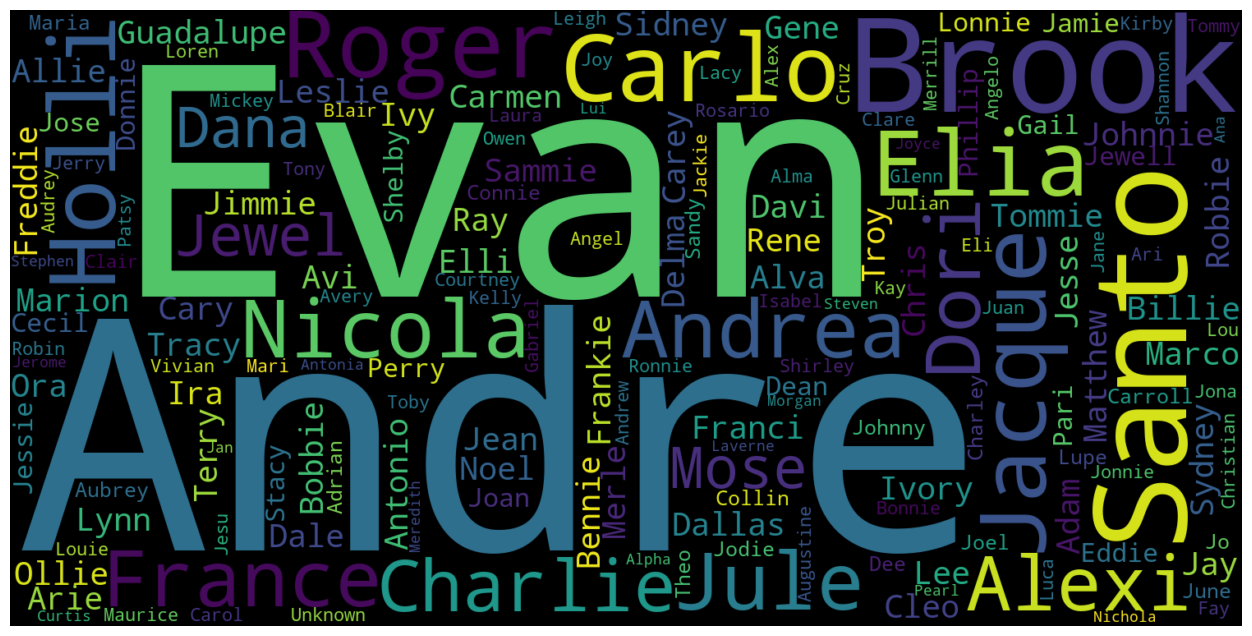

In [20]:
names_column = names.name
names_corpus = " ".join(names_column)
names_wordcloud = WordCloud(background_color="black",
                            height =750, width=1500,
                            max_words = 175).generate(names_corpus)

plt.figure(figsize = (16, 8))
plt.imshow(names_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### ⤹ Number of babies born over the years

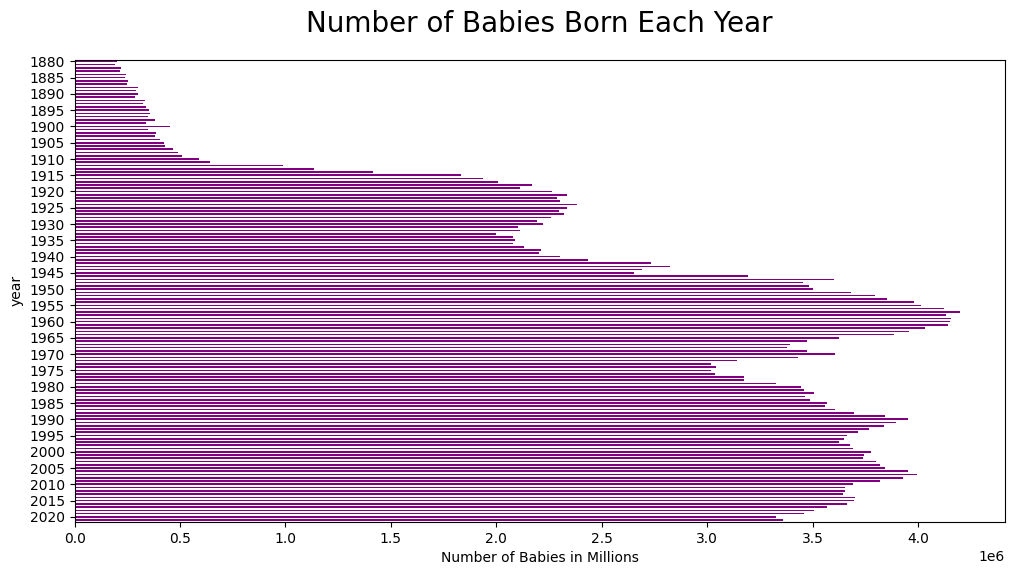

In [21]:
babies_per_year = names.groupby('year').year_count.sum()
babies_per_year.plot(kind = 'barh', x = "year_count", figsize = (12, 6), 
                     color = "purple");
plt.style.use('ggplot')
plt.yticks(ticks = (range(0, len(babies_per_year), 5)), labels = range(1880, 2022, 5), fontsize = 10)
plt.title('Number of Babies Born Each Year', fontsize = 20, pad = 20, color = 'black');
plt.xlabel('Number of Babies in Millions');
plt.gca().invert_yaxis();

### ⤹ Unique baby names over the years

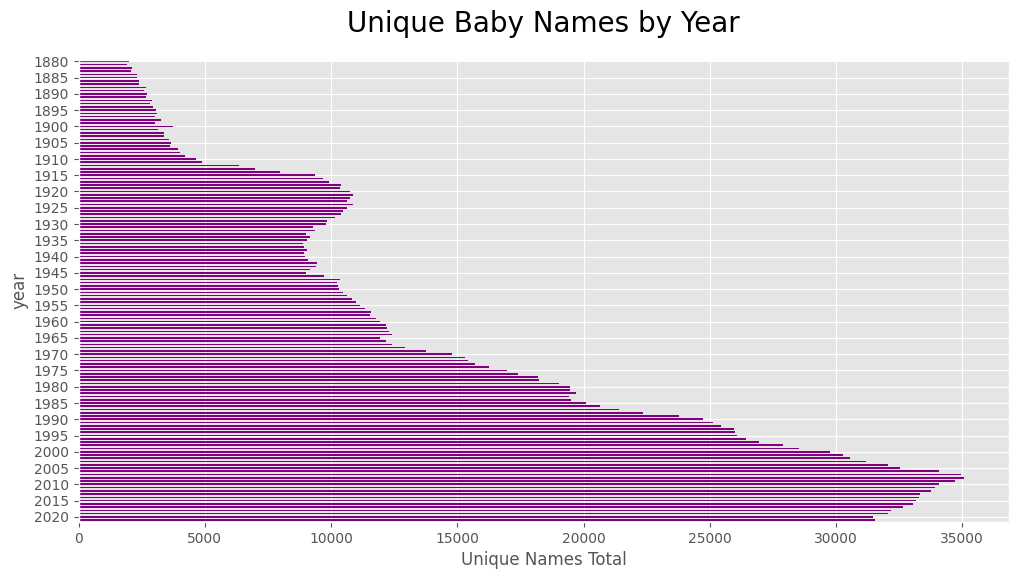

In [22]:
unique_names = names.groupby('year').name.count()
unique_names.plot(kind = 'barh', figsize = (12, 6), color = "purple");
plt.yticks(ticks = range(0, len(unique_names), 5), labels = range(1880, 2022, 5));
plt.title('Unique Baby Names by Year', fontsize = 20, pad = 20, color = 'black');
plt.xlabel('Unique Names Total');
plt.gca().invert_yaxis();

---
---
## → Adding popularity and ranking to the data

In [23]:
mary_1880 = names[(names.name == 'Mary') & (names.year == 1880)]
babies_1880 = names.groupby(['year', 'gender']).year_count.sum().head(2)
female_mary_1880_percent = mary_1880.iloc[0]['year_count'] / babies_1880.iloc[0] * 100
print(f"In the year 1880, the name Mary accounted for {female_mary_1880_percent:.2f}% of baby girl names.\n")

In the year 1880, the name Mary accounted for 7.76% of baby girl names.



#### `df.transform()` [(docs)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html)
```
DataFrame.transform(func, axis=0, *args, **kwargs)
Call func on self producing a DataFrame with the same axis shape as self.
```
* The `transform()` method allows you to execute a function for each value of the DataFrame.

```
Two major differences between apply and transform
There are two major differences between the transform and apply groupby methods.

Input:
apply implicitly passes all the columns for each group as a DataFrame to the custom function.
while transform passes each column for each group individually as a Series to the custom function.
Output:
The custom function passed to apply can return a scalar, or a Series or DataFrame (or numpy array or even list). The custom function passed to transform must return a sequence (a one dimensional Series, array or list) the same length as the group. So, transform works on just one Series at a time and apply works on the entire DataFrame at once.
```

In [24]:
names['popularity'] = names.year_count.div(names.groupby(['year', 
                                                        
                                            'gender']).year_count.transform('sum')) \
                                            * 1000000

In [25]:
names.sample(5)

year     name gender  year_count  popularity
10285    1884  Wilhelm      M           6          52
277007   1930    Peter      F          16          14
1592020  2008   Sutton      F          47          25
1458222  2004   Celena      F          44          24
1310045  1999   Nelida      F          19          11

In [26]:
names['ranking'] = names.groupby(['year', 
                                'gender'], 
            group_keys = False).year_count.apply(lambda x: x.rank(ascending = False))

In [27]:
names.sample(5)

year       name gender  year_count  popularity  ranking
1405001  2002      Rasha      F           8           4    11644
883786   1981     Sheena      F         657         394      356
815460   1977     Birdie      F           8           5     7228
138928   1917     Rachel      F        1339        1238      157
1044934  1988  Ascencion      M           5           3     7878

### `most_popular_year()`

In [28]:
def most_popular_year(year, gender, number):
    return names[(names.year == year) & (names.gender == gender)].head(number)

In [29]:
most_popular_year(2000, "M", 5)

year         name gender  year_count  popularity  ranking
1350666  2000        Jacob      M       34489       17564        1
1350667  2000      Michael      M       32040       16316        2
1350668  2000      Matthew      M       28575       14552        3
1350669  2000       Joshua      M       27538       14024        4
1350670  2000  Christopher      M       24935       12698        5

In [30]:
most_popular_year(2000, "F", 5)

year     name gender  year_count  popularity  ranking
1333008  2000    Emily      F       25957       14296        1
1333009  2000   Hannah      F       23085       12714        2
1333010  2000  Madison      F       19968       10997        3
1333011  2000   Ashley      F       17997        9912        4
1333012  2000    Sarah      F       17708        9753        5

### `name_filter()`

In [31]:
def name_filter(name, gender, number):
    return names[(names.name == name) & (names.gender == gender)].sort_values(by = "popularity", ascending = False).head(number)

In [32]:
name_filter("Evan", "F", 5)

year  name gender  year_count  popularity  ranking
1095781  1991  Evan      F         141          75     1220
1456324  2004  Evan      F         134          73     1505
1728010  2012  Evan      F         124          70     1691
1590201  2008  Evan      F         131          69     1707
1121002  1992  Evan      F         127          69     1325

### `plot_popularity()`

In [33]:
def plot_popularity():
    name = input("\n Enter a name: ").capitalize()
    gender = input(" Gender: Enter M for male or F for female: ").upper()
    
    plt.figure(figsize=(10, 6), facecolor="#222222");
    
    plt.style.use("ggplot");

    print("")
    print(".........." * 5)
    print("Loading the data...")
    print("There are almost 2 million records...")
    print("So I will need to do some data wrangling...")
    print("Give me just a sec...\n")
    
    plt.style.use("ggplot");
    plt.figure(figsize=(10, 6), facecolor="#222222");
    ax = plt.axes();
    
    try: 
        data = names[(names.name == name) & \
                     (names.gender == gender)].sort_values(by='year')
        data.popularity.plot(kind='bar', color='cyan', edgecolor = 'blue');

        years = list(data.year)
        labels = []
        for idx, year in enumerate(years):
            if idx % 5 == 0:
                labels.append(year)

        if gender == "F":
            gender_label = "Females"
        else:
            gender_label = "Males"

        ax.set_xticks(ticks=range(0, len(data), 5), labels=labels, 
                      fontsize=10, color = "white");
        ax.tick_params(labelrotation=40, labelcolor = 'white');
        ax.set_title(f"Popularity Distribution {gender_label} Named {name}", \
                     fontsize=16, pad=20, color = 'white');
        ax.set_ylabel("Popularity", fontsize=14, color = 'white');
        ax.set_xlabel("Years", fontsize=14, color = 'white');
        
        print("")
        print(".........." * 5)
        print("See your name popularity graph below.")
        print(".........." * 5)
        print("")
        plt.show();
    except IndexError:
        print(".........." * 5)
        print("OOOPS! Try again! Check your spelling maybe? If you are sure you")
        print("input a valid name, then keep in mind any names with fewer than 5 \
                births")
        print("in a year are not included in the data.\n")
        print(".........." * 5)

### ⤹ Plotting popularity


 Enter a name:  George
 Gender: Enter M for male or F for female:  M



..................................................
Loading the data...
There are almost 2 million records...
So I will need to do some data wrangling...
Give me just a sec...


..................................................
See your name popularity graph below.
..................................................



<Figure size 1000x600 with 0 Axes>

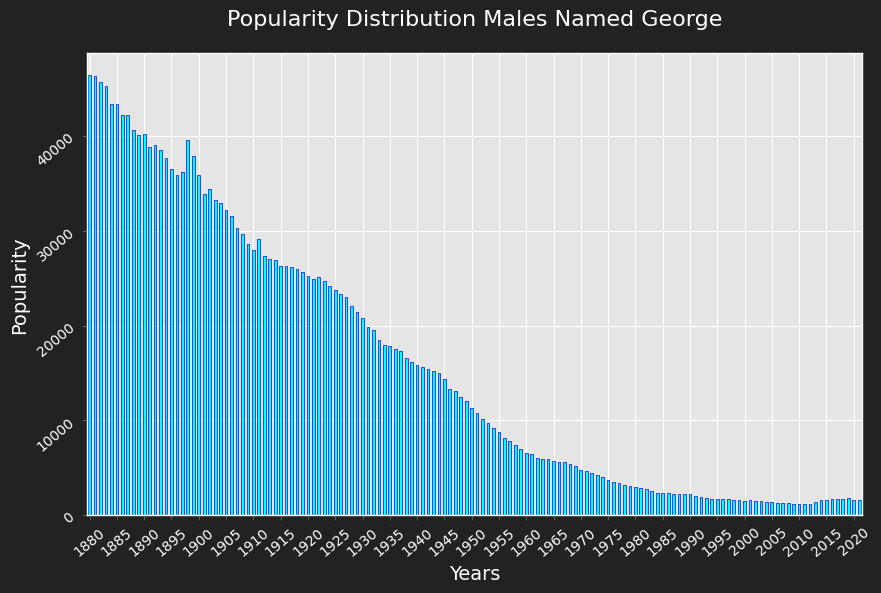

In [32]:
plot_popularity()

### `how_many_ever()`

In [32]:
def how_many_ever():
    %matplotlib inline
    
    print("")
    name = input("Input a name: ").capitalize()
    gender = input("Input M for male, F for female, or 'both': ").capitalize()
    
    if (gender == "F") or (gender == "M"):
        result = names[(names.name == name) & \
                       (names.gender == gender)].year_count.sum()
    elif (gender == None) or (gender == 'Both'):
        result = names[names.name == name].year_count.sum()
    if gender == "F":
        gen = "females"
    elif gender == "M":
        gen = "males"
    elif (gender == None) or (gender == "Both"):
        gen = "people"
        
    
    if result < 25:
        image = "http://www.evanmarie.com/content/files/apps/name_popularity/names_01.png"
        message = "Now, that is unique AF! NOICE!"
    elif result < 3000:
        image = "http://www.evanmarie.com/content/files/apps/name_popularity/names_02.png"
        message = "Wow, that's pretty rare. I like it!"
    elif result < 100000:
        image = "http://www.evanmarie.com/content/files/apps/name_popularity/names_03.png"
        message = "Unique enough, but still often able to find custom items with your name on it."
    elif result < 500000:    
        image = "http://www.evanmarie.com/content/files/apps/name_popularity/names_04.png"
        message = "Nice and popular but it's nice when half of your friends don't have the same name as you."
    elif result < 1000000:    
        image = "http://www.evanmarie.com/content/files/apps/name_popularity/names_05.png"
        message = "Not bad! Almost a Mary or a James!"
    else:
        image = "http://www.evanmarie.com/content/files/apps/name_popularity/names_06.png"
        message = "Is there such a thing as too popular? Really though?"
    
    print(f"\nThere have been a total of {result:,} {gen} named {name.upper()} in the USA between 1880 and 2021.")
    print(message, '\n')
    img = Image.open(urlopen(image))
    img = img.resize((200, 200))
    display(img)
    print("")

### ⤹ How many people overall for a name

Input a name:  Chester
Input M for male, F for female, or 'both':  F



There have been a total of 828 females named CHESTER in the USA between 1880 and 2021.
Wow, that's pretty rare. I like it! 



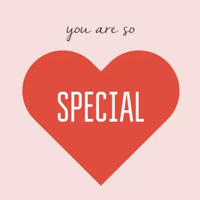

In [144]:
how_many_ever()

### `popularity_vs_ranking()`

In [34]:
def popularity_vs_ranking(name, gender):
    
    data = names.loc[(names.name == name) & \
                     (names.gender == gender), ['name', 'gender', 'year', \
                                                'ranking', 'popularity']]
    
    data = data.set_index('year')
    
    if gender == "F":
        gen = "Females"
    else:
        gen = "Males"
    
    
    fig, ax1 = plt.subplots(figsize=(10, 7), facecolor='#222222')
    ax1.bar(x=data.index, height=data['popularity'], \
            label="Popularity", color='cyan', edgecolor="blue")
    
    ax2 = ax1.twinx()
    ax2.plot(data.index, data.ranking, color = 'purple',
             label = "Ranking", linewidth=2.25)
    
    ax1.set_xlabel("Year", fontsize = 15, color = "white")
    ax1.set_ylabel("Babies per Million", fontsize = 15, color = "white")
    ax2.set_ylabel("Popularity", fontsize = 15, color = "white")
    ax1.set_title(f"{name}: popularity and ranking for {gen} over time", \
                  fontsize = 18, pad = 20, color = "white")

    ax1.tick_params(labelsize = 12, labelcolor = "white")
    ax2.tick_params(labelsize = 12, labelcolor = "white")
    ax1.legend(loc = 2, fontsize = 15, labelcolor = 'black')
    ax2.legend(loc = 1, fontsize = 15, labelcolor = 'black')
    plt.show()

### ⤹ Plotting popularity vs. ranking

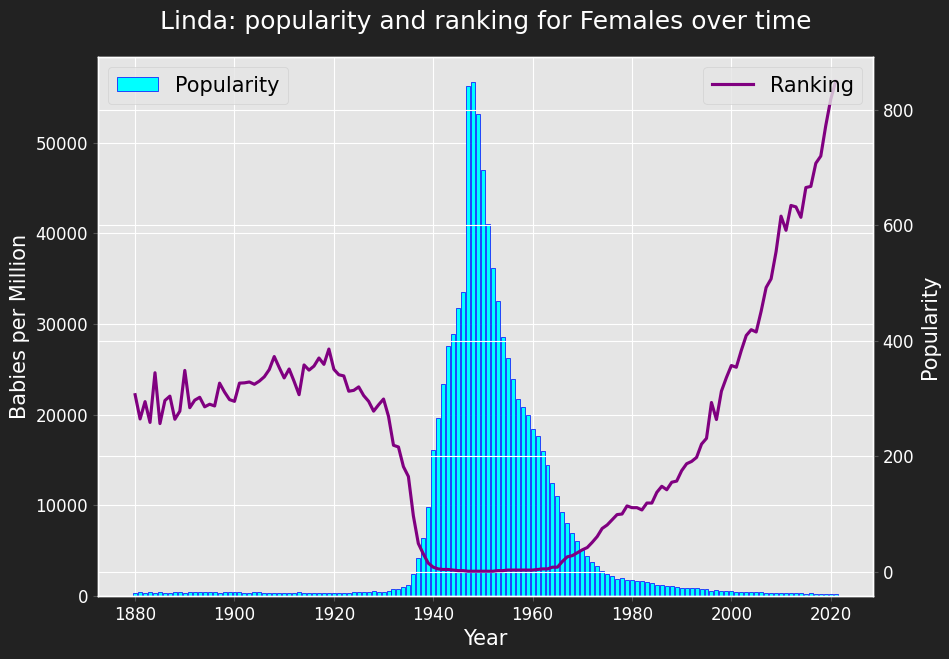

In [34]:
popularity_vs_ranking("Linda", "F")

### `plot_subplots()`

In [35]:
def plot_subplots(plot_list, plot_name = None):
    import warnings; warnings.filterwarnings("ignore")
    
    colors = ['white', 'lightcoral', 'tomato', 'yellow', 'chartreuse',
              'palegreen', 'peachpuff', 'lightgreen', 'lime', 'turquoise',
              'aqua', 'deepskyblue', 'dodgerblue', 'cornflowerblue', 'lavender',
              'violet', 'fuchsia', 'deeppink', 'lavenderblush', 'pink', 
              'paleturquoise', 'springgreen']
    colors = random.sample(colors, k=len(plot_list))
    plt.style.use("ggplot");
    rows = round(len(plot_list) / 2)
    fig, axs = plt.subplots(nrows=rows, ncols=2, 
                        figsize = (13, rows*4), facecolor="#222222", 
                           constrained_layout=True)


    for idx, name in enumerate(plot_list):
        current_name = name[0]
        current_gender = name[1]

        plt.style.use("ggplot");
        ax = plt.axes();
        ax.remove()
        plt.subplot(rows, 2, idx+1, facecolor = "#555555")
        data = names[(names.name == current_name) & \
                 (names.gender == current_gender)].sort_values(by='year')
        data.popularity.plot(kind='bar', color=colors[idx]);

        years = list(data.year)
        labels = []

        for idx, year in enumerate(years):
            if idx % 10 == 0:
                labels.append(year)

        if current_gender == "F":
            gender_label = "(female)"
        else:
            gender_label = "(male)"
            
            
        plt.suptitle(plot_name, color = 'white', fontsize = 25)
        plt.xticks(ticks=range(0, len(data), 10), labels=labels, fontsize=10, color = "white");
        plt.grid(color='#777777')
        plt.yticks(fontsize=9, color = "white");
        plt.tick_params(labelrotation=40, labelcolor = 'white', color='white');
        plt.title(f"{current_name.upper()} {gender_label}: Popularity Trend (1880-2021)", \
                      fontsize=15, pad=10, color = 'white');
        plt.ylabel("Popularity", fontsize=12, color = 'white');
        plt.xlabel("Years", fontsize=12, color = 'white');

---
---
## → What names were popular across the time scale?

* [`df.merge()`, `how = 'inner'`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html):
```
how{‘left’, ‘right’, ‘outer’, ‘inner’, ‘cross’}, default ‘inner’

Type of merge to be performed.
- left: use only keys from left frame, similar to a SQL left outer join; preserve key order.
- right: use only keys from right frame, similar to a SQL right outer join; preserve key order.
- outer: use union of keys from both frames, similar to a SQL full outer join; sort keys lexicographically.
- inner: use intersection of keys from both frames, similar to a SQL inner join; preserve the order of the left keys.
- cross: creates the cartesian product from both frames, preserves the order of the left keys.
```

### ⤹ Top 4 names populary around 1880 and still popular today:

In [36]:
female_2021 = most_popular(2021, 'F', 40); female_1880 = most_popular(1880, "F", 40)

female_overall = female_2021[['name', 'gender', 
                              'year_count']].merge(female_1880[['name',
                                                            'year_count']],
                                                       how = 'inner', on = 'name',
                                                       suffixes = ('_2021', '_1880'))

In [37]:
male_2021 = most_popular(2021, 'M', 24); male_1880 = most_popular(1880, 'M', 24)

male_overall = male_2021[['name', 'gender', 
                          'year_count']].merge(male_1880[['name', \
                                                  'year_count']],
                                                  how = 'inner', on = 'name',
                                                  suffixes = ('_2021', '_1880'))

### `listify()`

In [38]:
def listify(df):
    the_list = []
    for row in df.iterrows():
        the_list.append((row[1][0], row[1][1]))
    return the_list

In [39]:
female_overall_list = listify(female_overall)
print(female_overall_list)
male_overall_list = listify(male_overall)
print(male_overall_list)

[('Emma', 'F'), ('Elizabeth', 'F'), ('Ella', 'F'), ('Grace', 'F')]
[('James', 'M'), ('William', 'M'), ('Henry', 'M'), ('Samuel', 'M')]


In [40]:
male_overall

name gender  year_count_2021  year_count_1880
0    James      M            12367             5927
1  William      M            12088             9532
2    Henry      M            11307             2444
3   Samuel      M             8501             1024

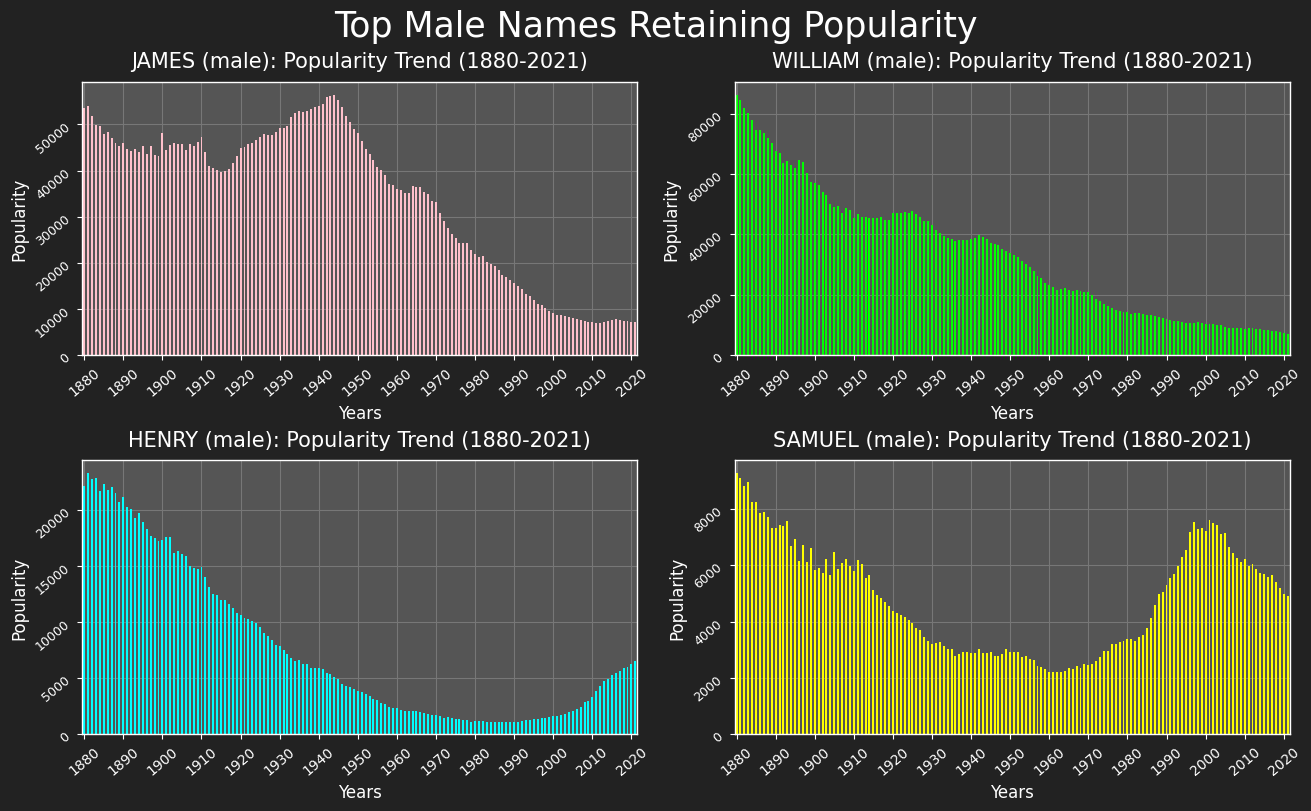

In [272]:
plot_subplots(male_overall_list, plot_name = "Top Male Names Retaining Popularity")

In [43]:
female_overall

name gender  year_count_2021  year_count_1880
0       Emma      F            15433             2003
1  Elizabeth      F             7190             1939
2       Ella      F             6987             1156
3      Grace      F             5486              982

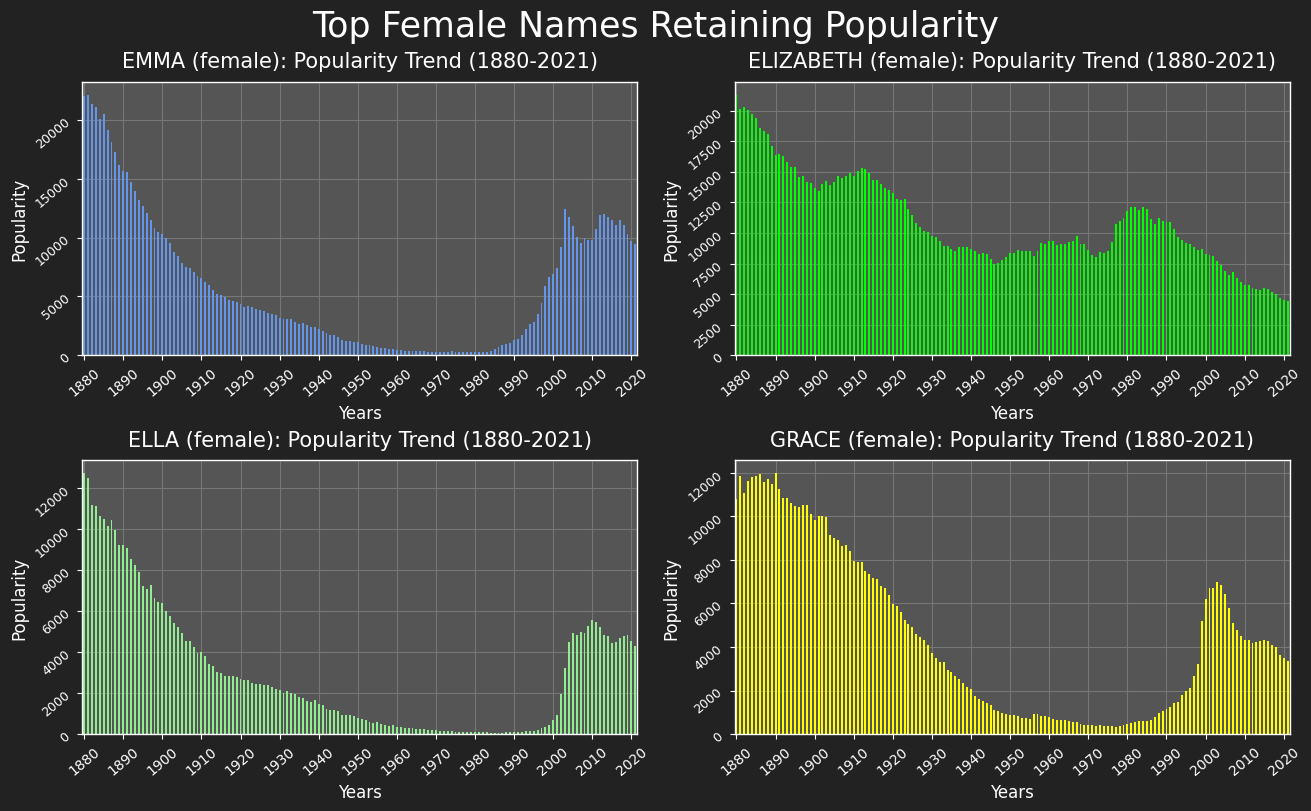

In [273]:
plot_subplots(female_overall_list, plot_name = "Top Female Names Retaining Popularity")

---
---
## → Changes in name popularity

#### `.shift()` - can shift the popularity by one year
```
DataFrame.shift(periods=1, freq=None, axis=0, fill_value=_NoDefault.no_default)[source]
Shift index by desired number of periods with an optional time freq.

When freq is not passed, shift the index without realigning the data. If freq is passed (in this case, the index must be date or datetime, or it will raise a NotImplementedError), the index will be increased using the periods and the freq. freq can be inferred when specified as “infer” as long as either freq or inferred_freq attribute is set in the index.
```

### ⤹ Adding `popularity_last_year` and`popularity_difference` and `percentage_change` since the last year columns

In [51]:
popularity_shifts = names[names.year >= 1889].copy()

In [52]:
names['popularity_last_year'] = names.groupby(['name', 'gender']).popularity.shift()
names["popularity_difference"] = names.popularity - names.popularity_last_year

In [53]:
names['percentage_change'] = names.popularity.div(popularity_shifts.popularity_last_year).sub(1).mul(100)
popularity_shifts = names[names.year >= 1889].copy()

### ⤹ Names with the largest decrease in popularity from one year to the next

In [54]:
popularity_shifts.nsmallest(6, 'popularity_difference')

year      name gender  year_count  popularity  ranking  \
339414  1937   Shirley      F       26821       25208        4   
330519  1936   Shirley      F       35162       33798        2   
461947  1950     Linda      F       80431       46952        1   
472252  1951     Linda      F       73977       41078        1   
961538  1985  Jennifer      F       42659       24791        3   
482719  1952     Linda      F       67081       36175        1   

        popularity_last_year  popularity_difference  percentage_change  
339414                 33798                  -8590                -25  
330519                 40396                  -6598                -16  
461947                 53200                  -6248                -12  
472252                 46952                  -5874                -13  
961538                 30029                  -5238                -17  
482719                 41078                  -4903                -12

### ⤹ Names with the largest increase in popularity from one year to the next

In [55]:
lginc = popularity_shifts[(popularity_shifts.popularity_last_year < 5)].nlargest(6, 'popularity_difference')

largest_increase_list = listify(lginc.drop(columns = ['year']))

lginc

year     name gender  year_count  popularity  ranking  \
758140   1974    Nakia      F        1134         773      226   
645899   1966  Tabatha      F         500         295      419   
1554130  2007  Jaslene      F         501         261      600   
1411681  2002  Omarion      M         418         215      535   
1520142  2006  Akeelah      F         403         212      708   
809111   1977   Kizzie      F         286         187      598   

         popularity_last_year  popularity_difference  percentage_change  
758140                      5                    768              15998  
645899                      3                    293              10332  
1554130                     3                    258               9809  
1411681                     3                    213               8266  
1520142                     3                    209               6249  
809111                      3                    184               6107

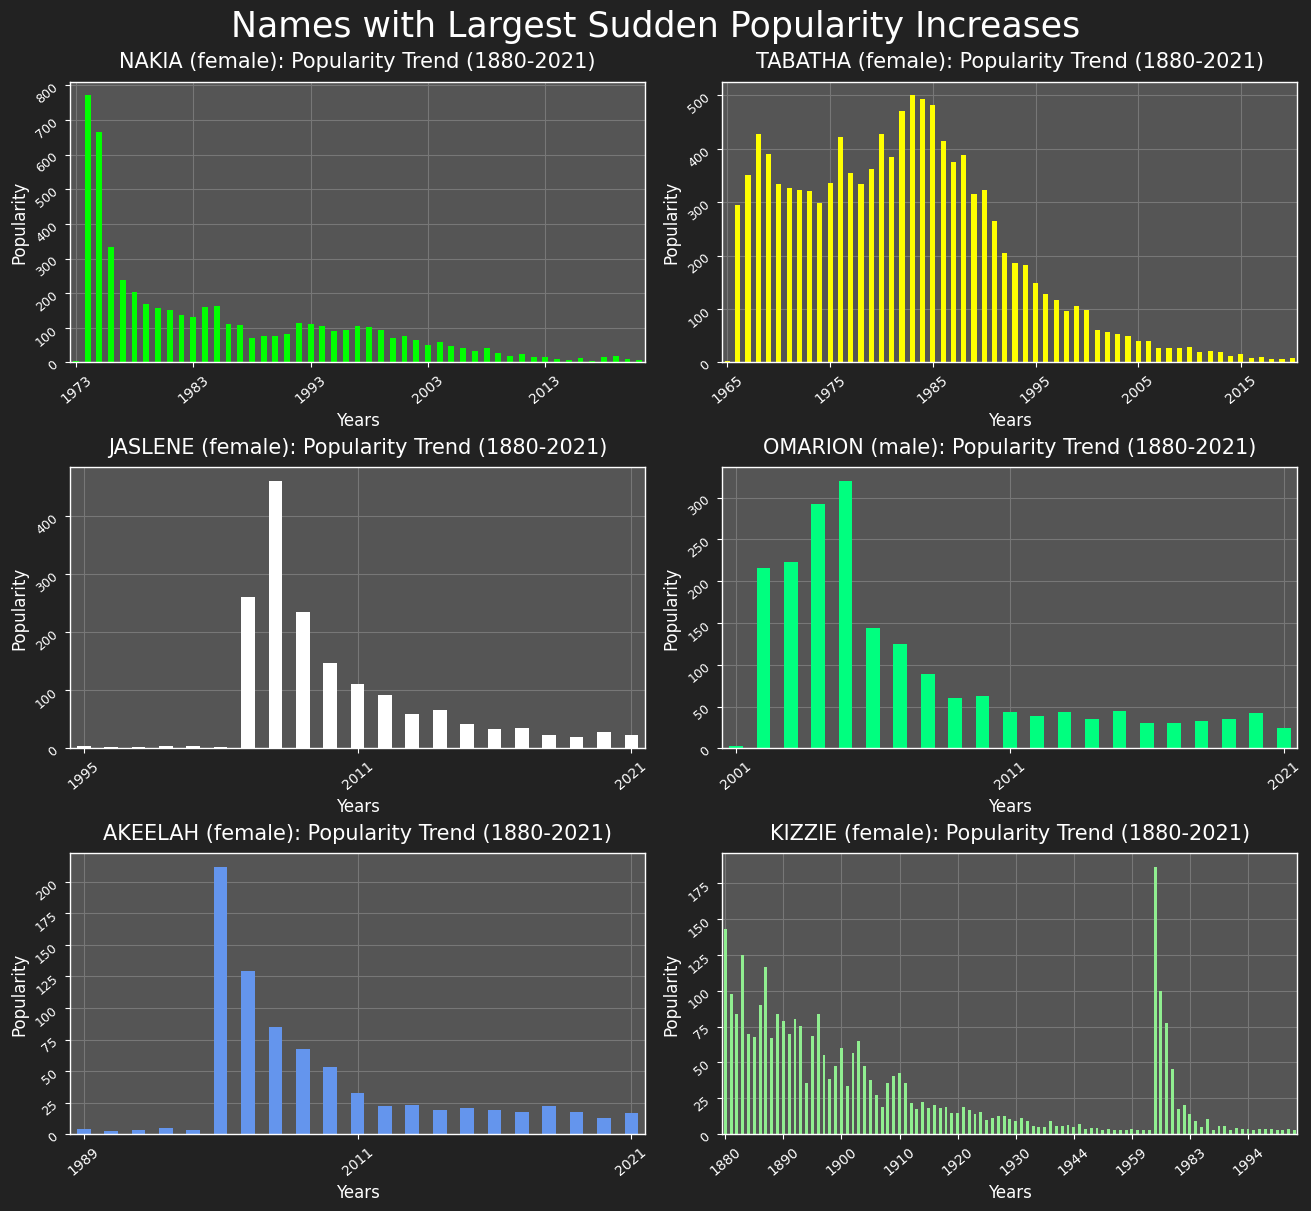

In [274]:
plot_subplots(largest_increase_list, "Names with Largest Sudden Popularity Increases")

### ⤹ Names with the largest percentage decrease in popularity from one year to the next

In [57]:
lpd = popularity_shifts[popularity_shifts.popularity_last_year > \
                                             1000].nsmallest(6, "percentage_change")

largest_percent_decrease = listify(lpd.drop(columns = ['year']))

lpd

year     name gender  year_count  popularity  ranking  \
758221   1974   Katina      F         766         522      307   
1120108  1992    Iesha      F         581         315      432   
1423957  2003  Ashanti      F         962         527      325   
515393   1955   Marian      F        1499         767      208   
175400   1920  Woodrow      M         774         727      183   
35687    1894   Grover      M         118        1019      137   

         popularity_last_year  popularity_difference  percentage_change  
758221                   1697                  -1175                -69  
1120108                  1011                   -696                -69  
1423957                  1639                  -1113                -68  
515393                   2066                  -1300                -63  
175400                   1845                  -1117                -61  
35687                    2573                  -1554                -60

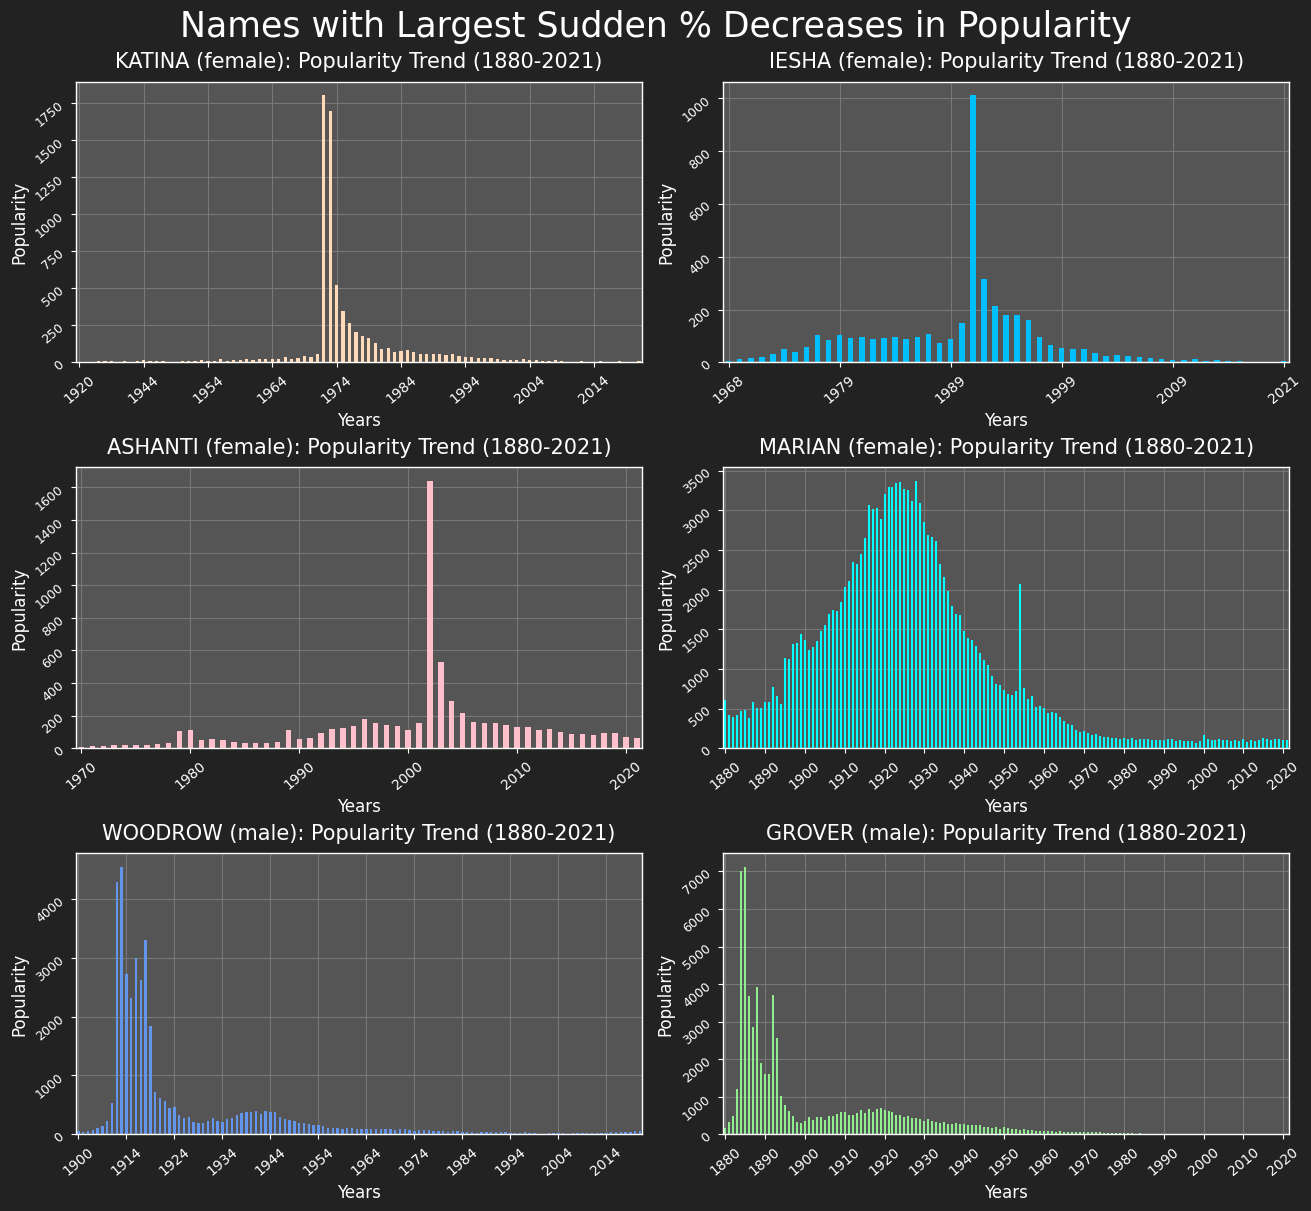

In [275]:
plot_subplots(largest_percent_decrease, plot_name = "Names with Largest Sudden % Decreases in Popularity")

---
---
## → Famous names and other name trends

In [45]:
good_famous_names = [('Kellen', 'M'), ('Montana', 'M'), ('Britney', 'F'), 
                    ('Whitney', 'F'), ('Shirley', 'F'), ('Prince', 'M'), 
                    ('Beyonce','F'), ("Taylor", "F"), ("Barack", "M"),
                    ("Keanu", "M"), ("Angelina", "F"), ("Oprah", "F"), 
                    ("Adele", "F"), ("Kanye", "M"), ("Mariah", "F"),
                    ("Selena", "F"), ("Kobe", "M"), ("Shaquille", "M"),
                    ("Cher", "F"), ("Denzel", "M"), ("Reese", "F"), ("Elvis", "M")]

bad_famous_names = [('Hillary','F'), ('Adolf', 'M'), ("Osama", "M"), ("Saddam", "M")]

song_names = [("Jolene", "F"), ("Rhiannon", "F"), ("Sharona", "F"),
              ("Adia", "F"), ("Fancy", "F"), ("Brandy", "F")]

character_names = [("Han", "M"), ("Bambi", "F"), ("Emma", "F"), 
                   ("Buffy", "F"), ("Jody", "F"), ("Betty", "F"),
                   ("Katniss", "F"), ("Barbie", "F"), ("Ken", "M"),
                   ("Luke", "M")]

slavic_names = [('Vladimir', 'M'), ('Mikhail', 'M'), ('Anya', 'F'),
                 ('Ekaterina', 'F'), ('Yelena', 'F'), ('Maxim', 'M'),
                ('Nikolai', 'M'), ('Ivanna', 'F'), ('Natasha', 'F'),
                ('Nadia', 'F')]

cuban_names = [('Jose', 'M'), ('Carlos', 'M'), ('Luis', 'M'),
                ('Monica', 'F'),('Erica', 'F'), ('Marisol', 'F')]

jewish_names = [("Tamar", "F"), ("Levi", "M"), ("Noam", "M"),
                ("Jacob", "M"), ("Ari", "M"), ("Chaim", "M"),
               ("Immanuel", "M"), ("Jael", "F")]

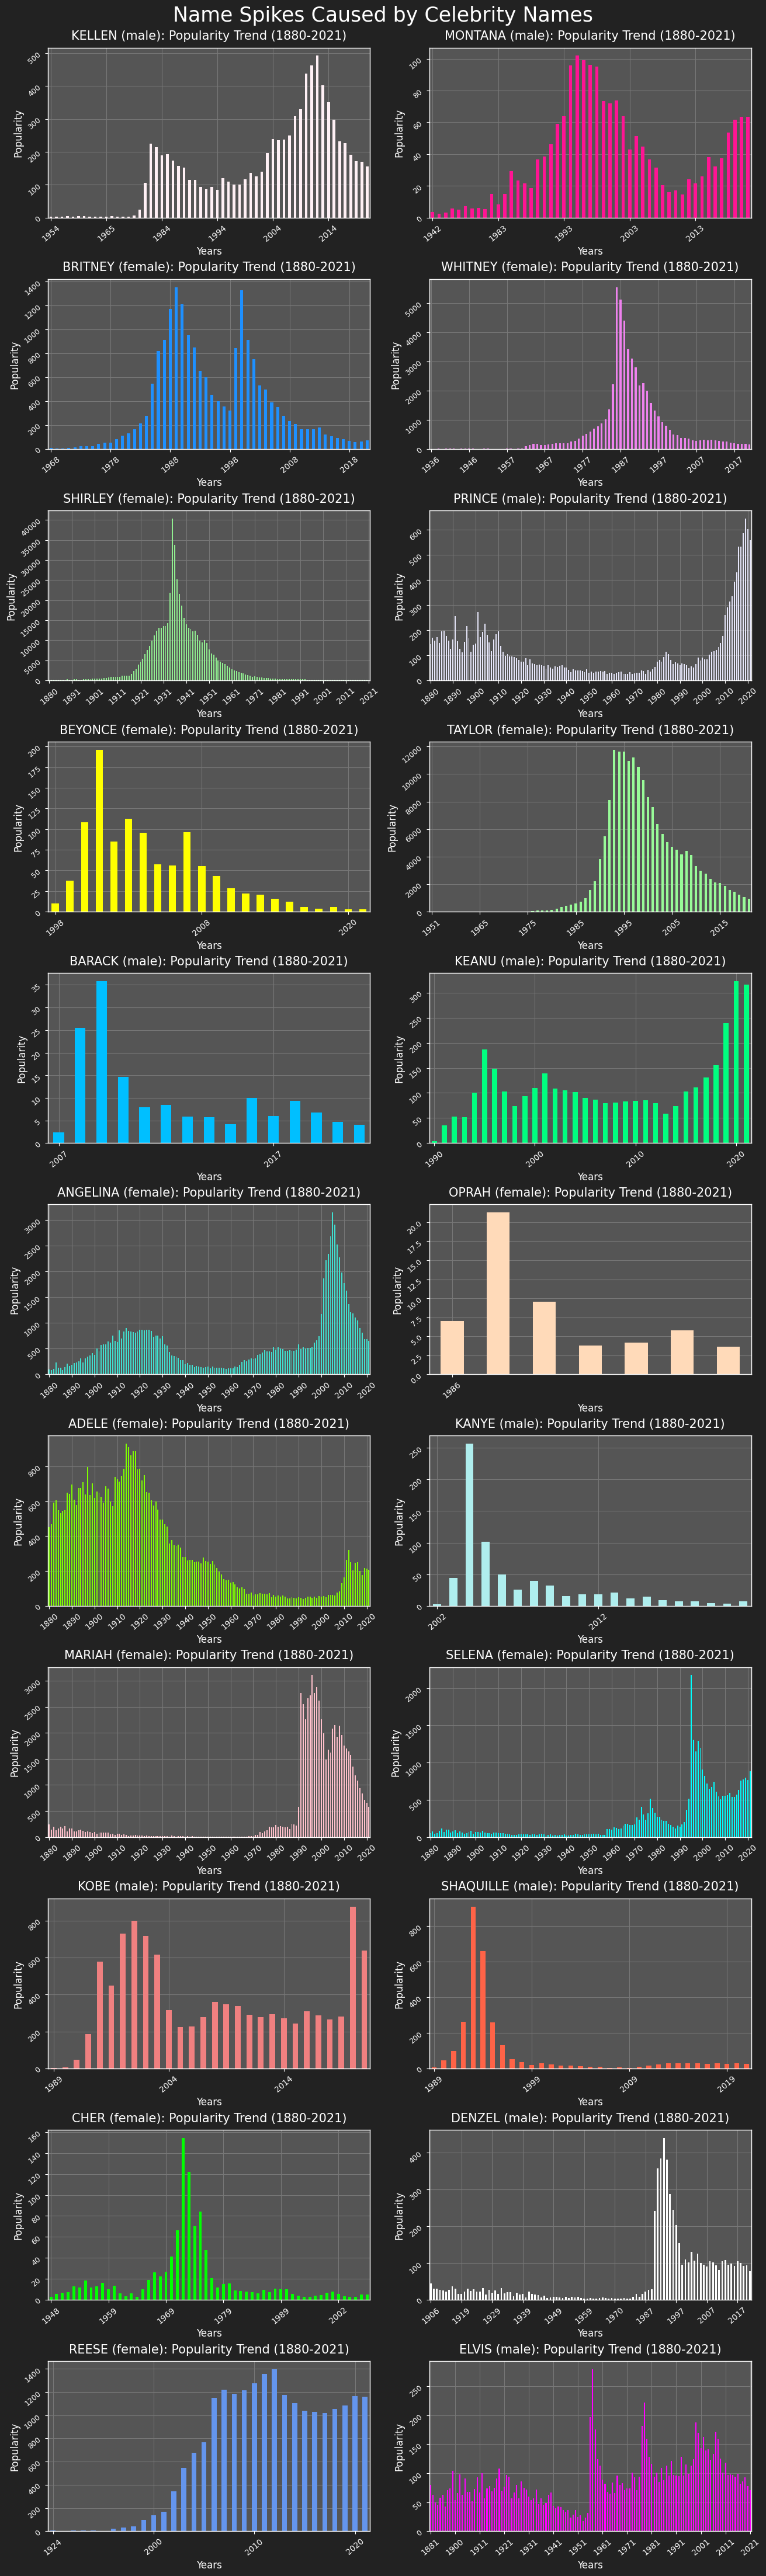

In [369]:
plot_subplots(good_famous_names, "Name Spikes Caused by Celebrity Names")

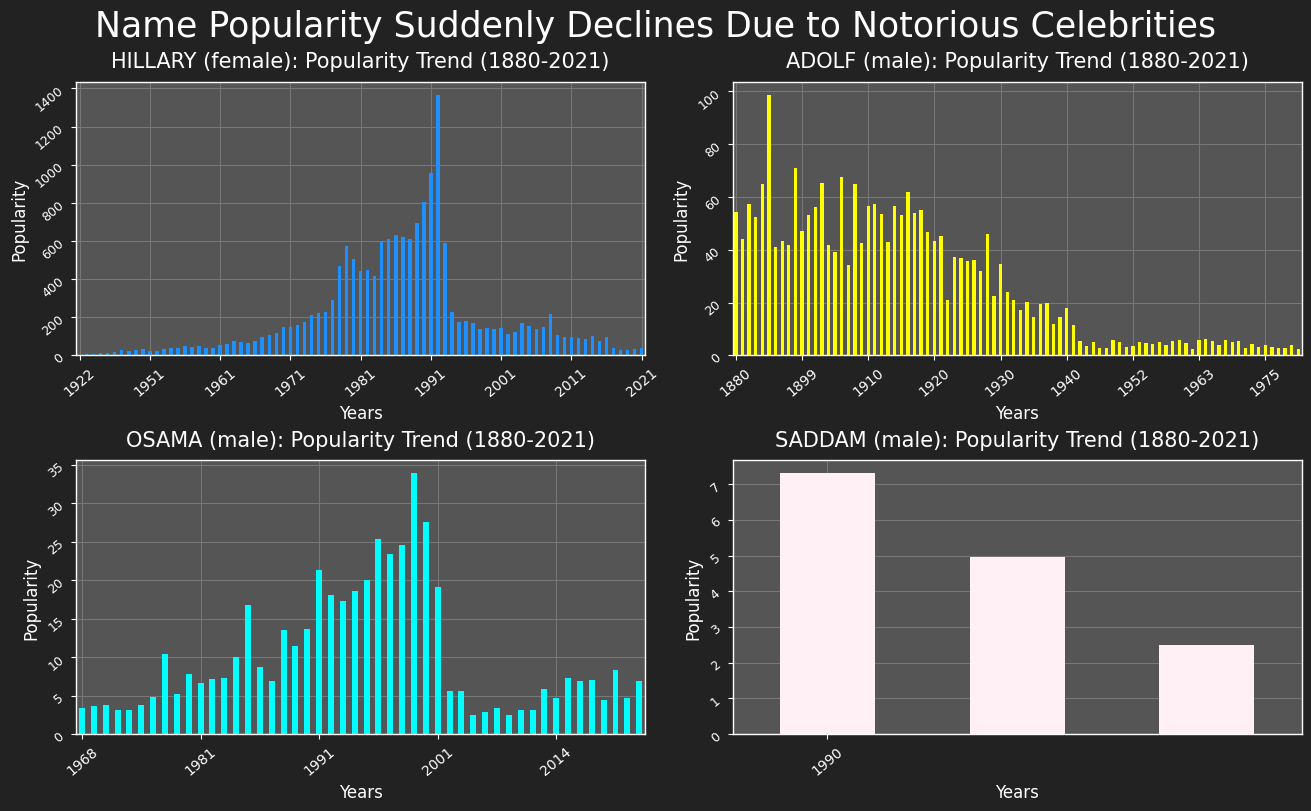

In [51]:
plot_subplots(bad_famous_names, "Name Popularity Suddenly Declines Due to Notorious Celebrities")

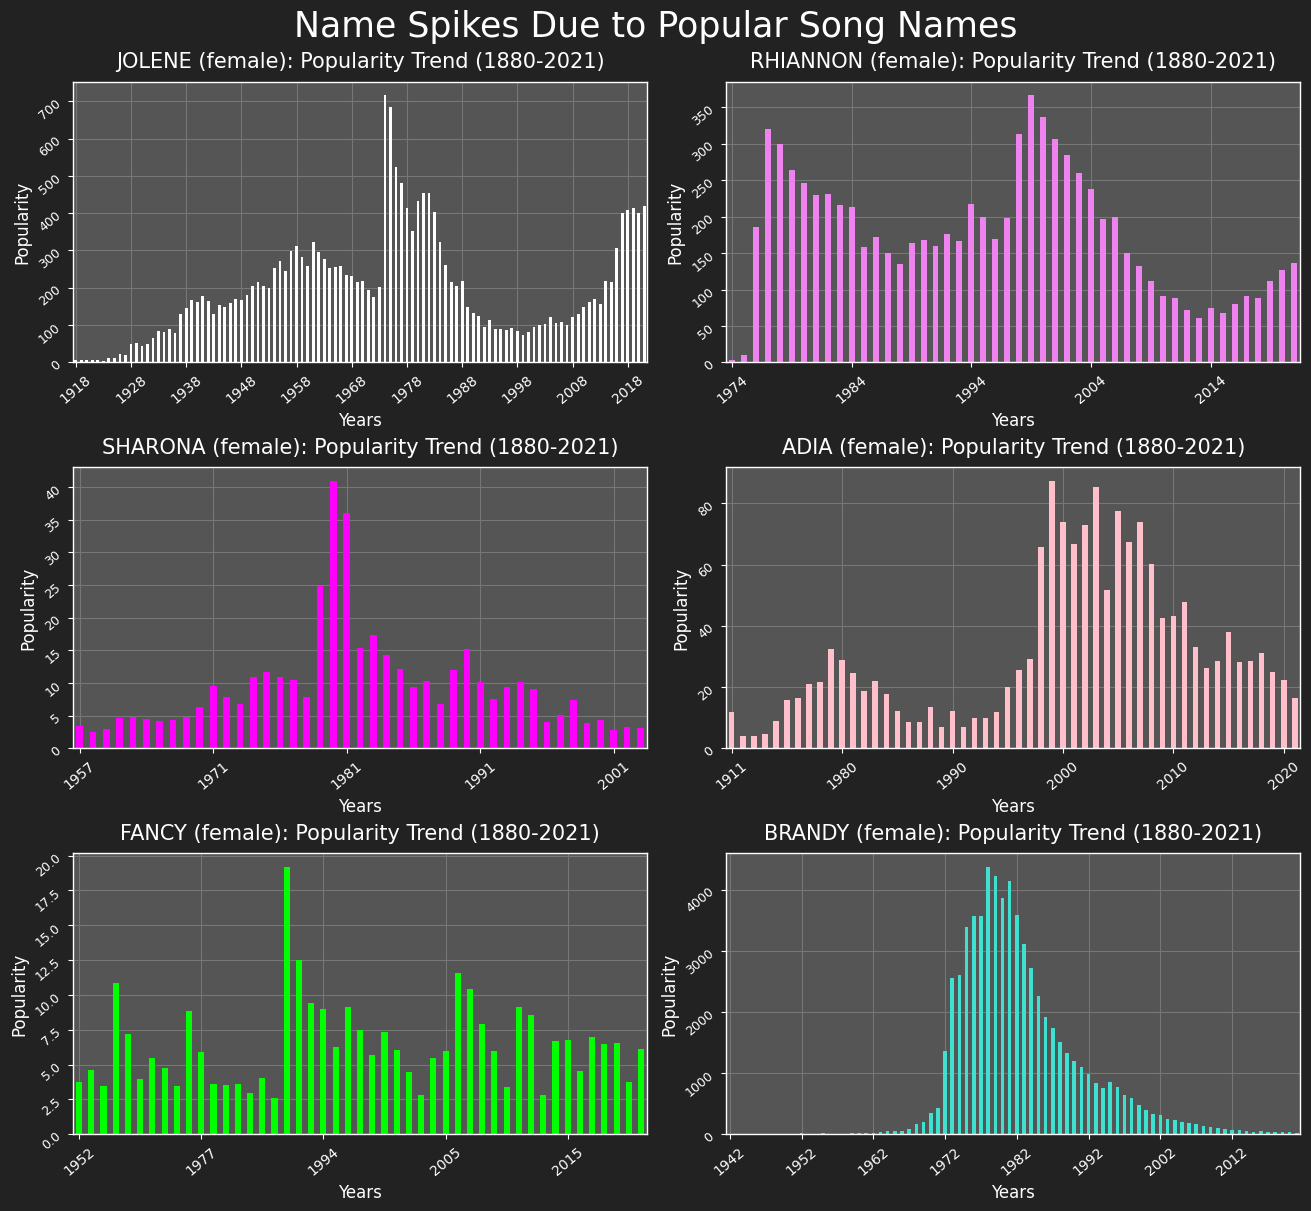

In [50]:
plot_subplots(song_names, "Name Spikes Due to Popular Song Names")

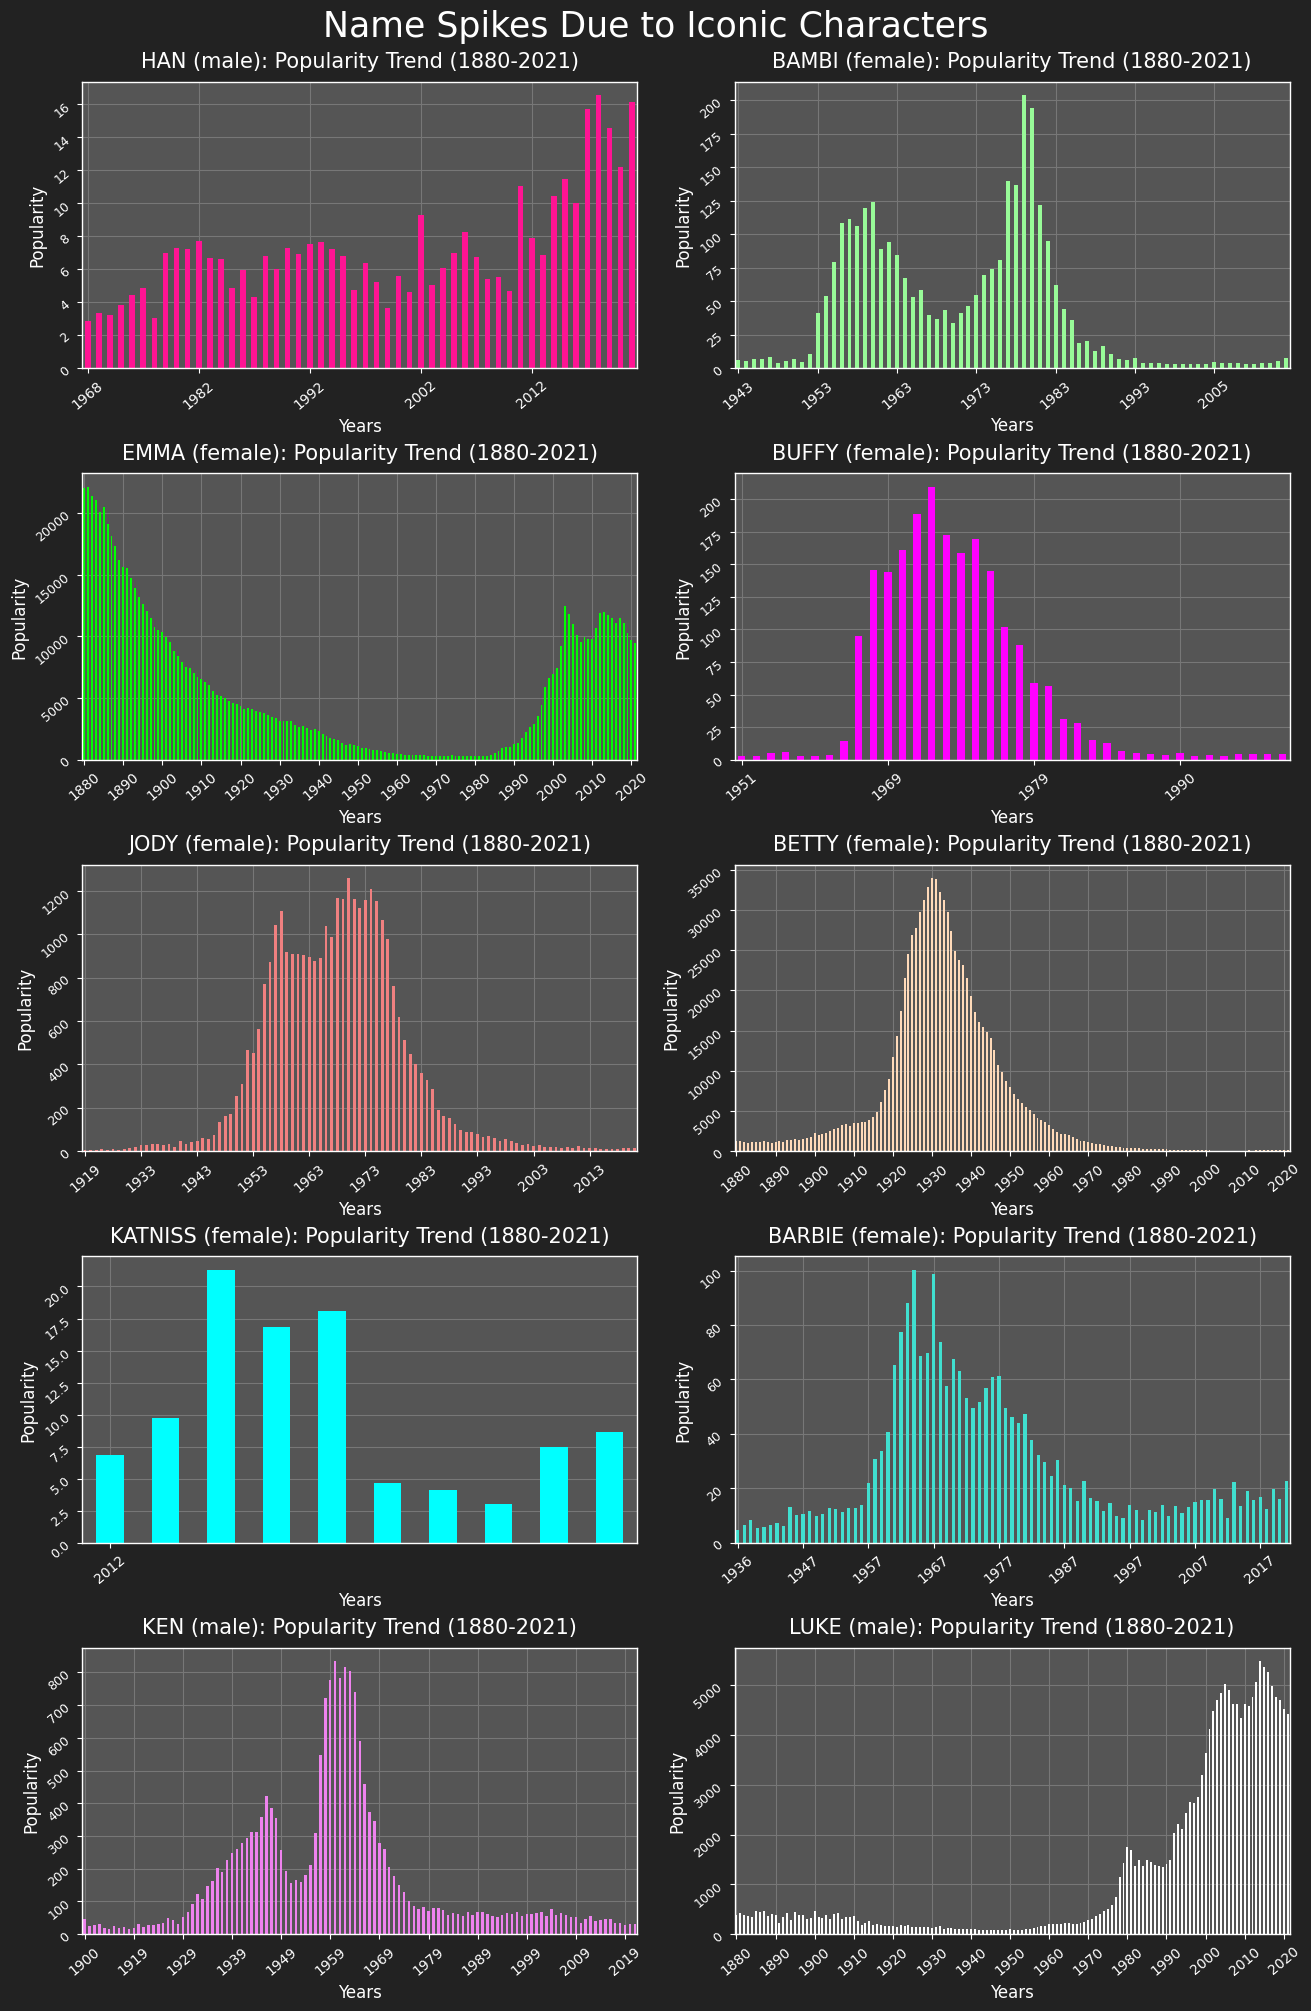

In [46]:
plot_subplots(character_names, "Name Spikes Due to Iconic Characters")

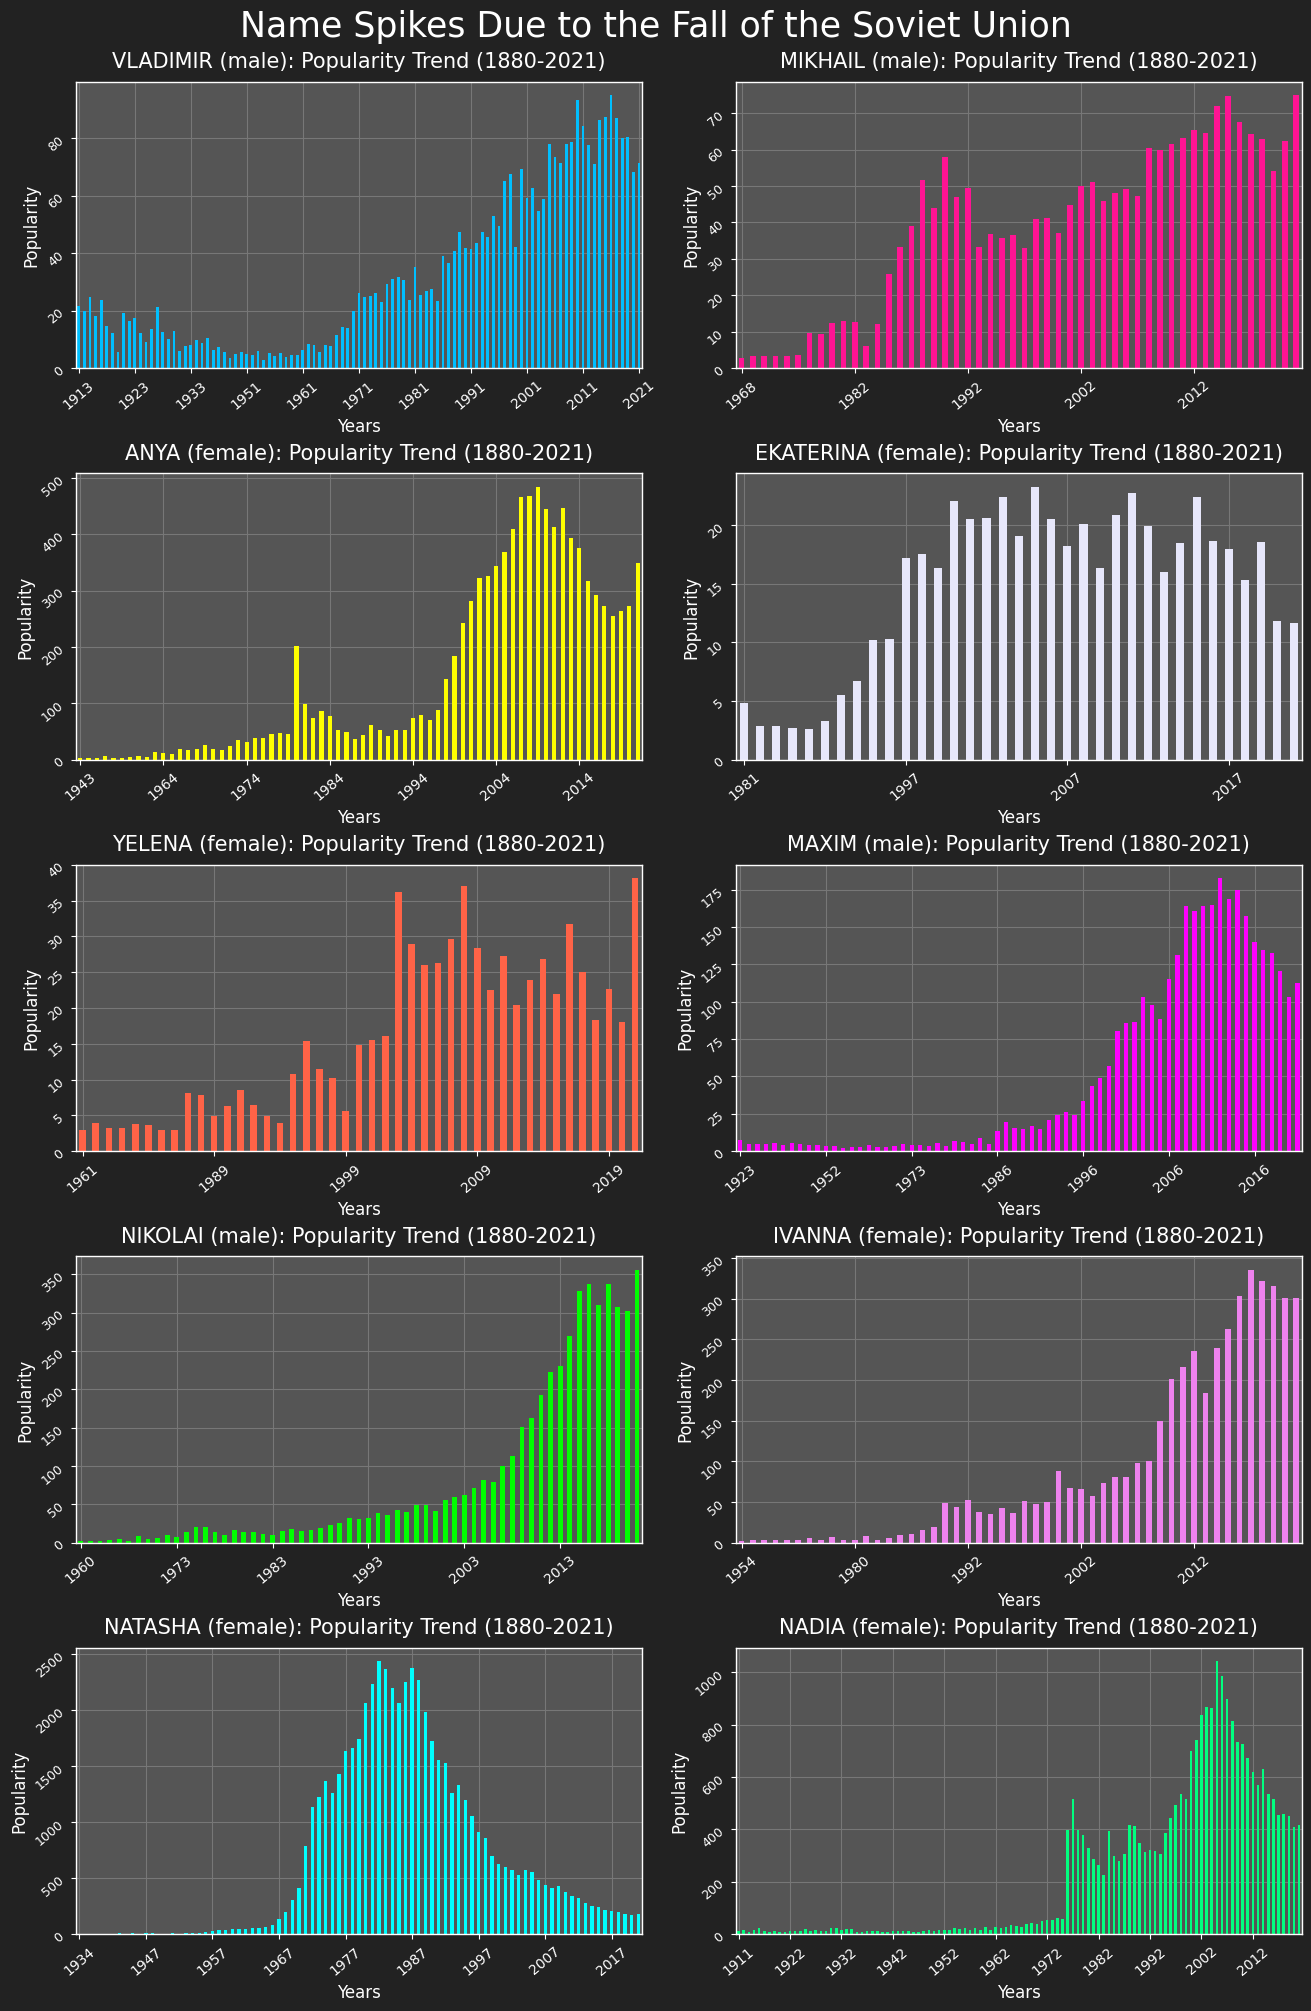

In [48]:
plot_subplots(slavic_names, "Name Spikes Due to the Fall of the Soviet Union")

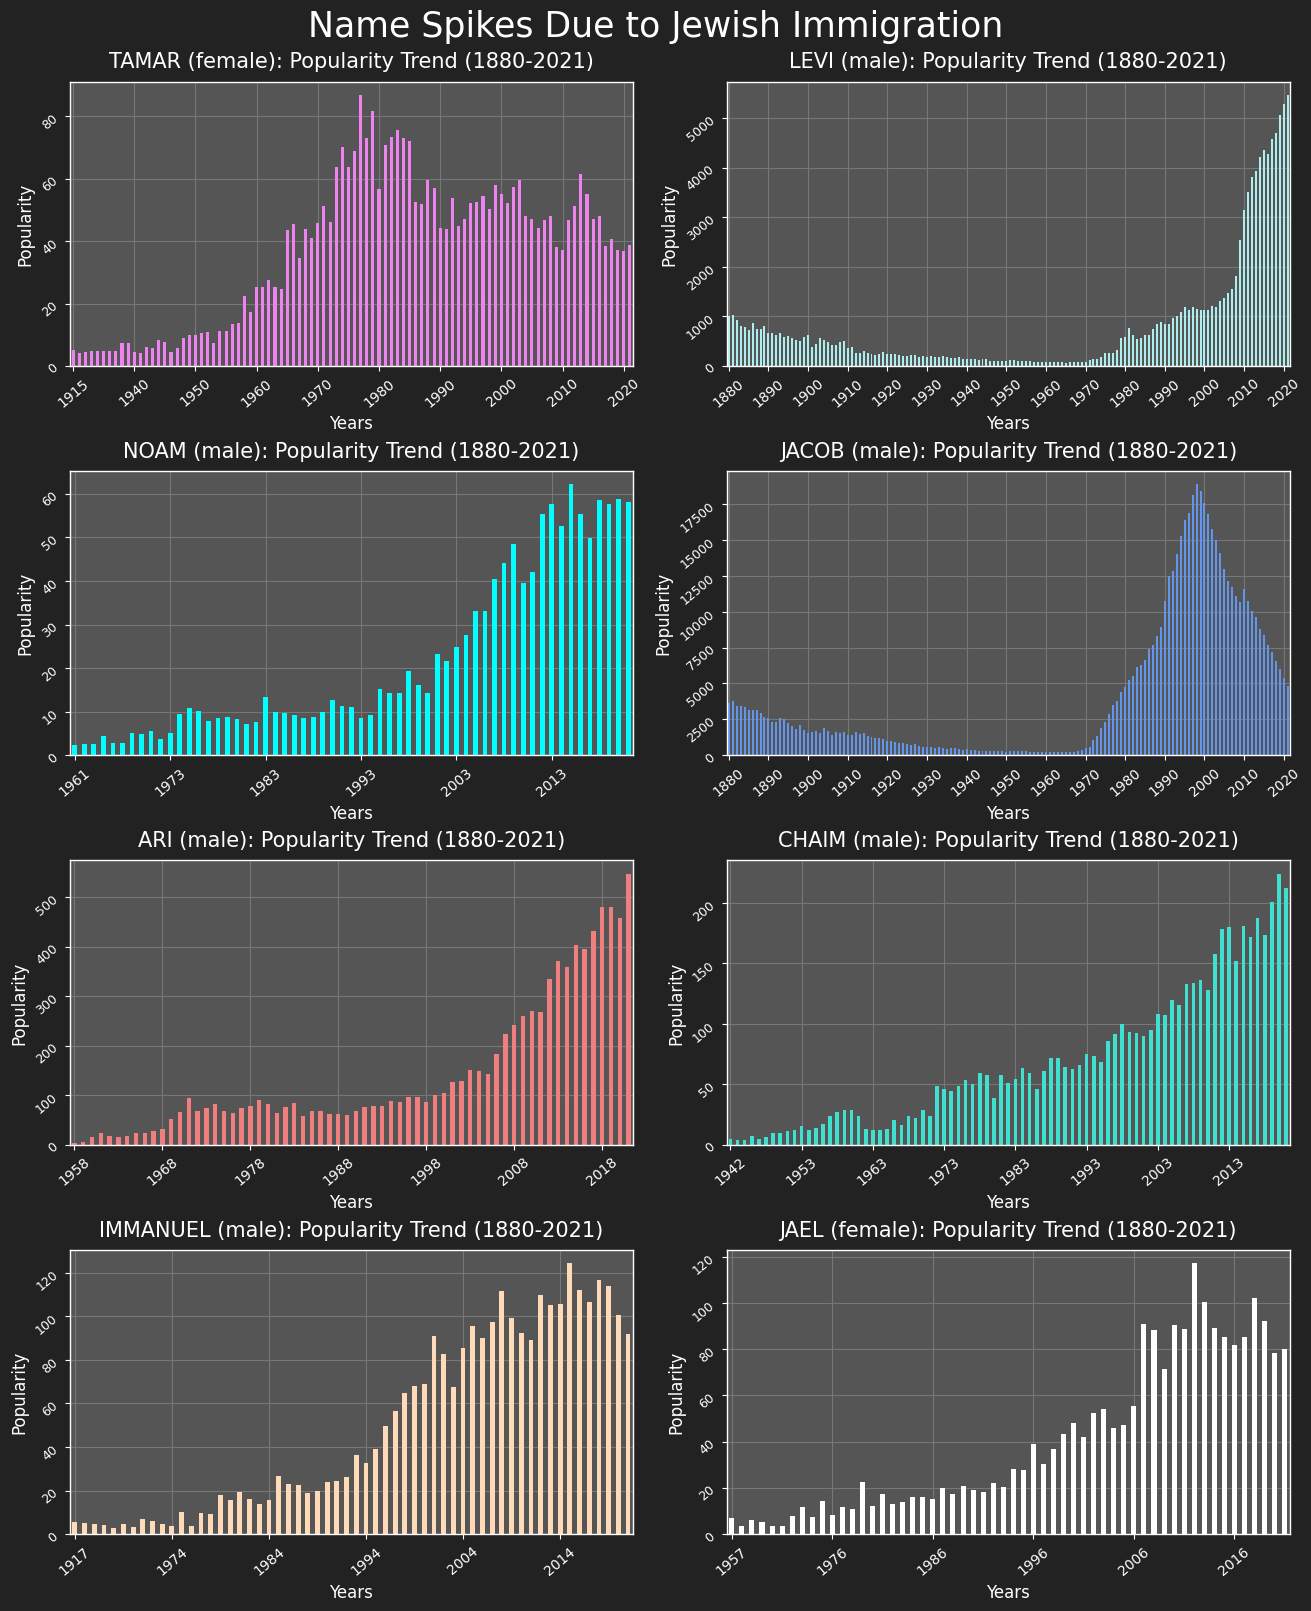

In [49]:
plot_subplots(jewish_names, "Name Spikes Due to Jewish Immigration")

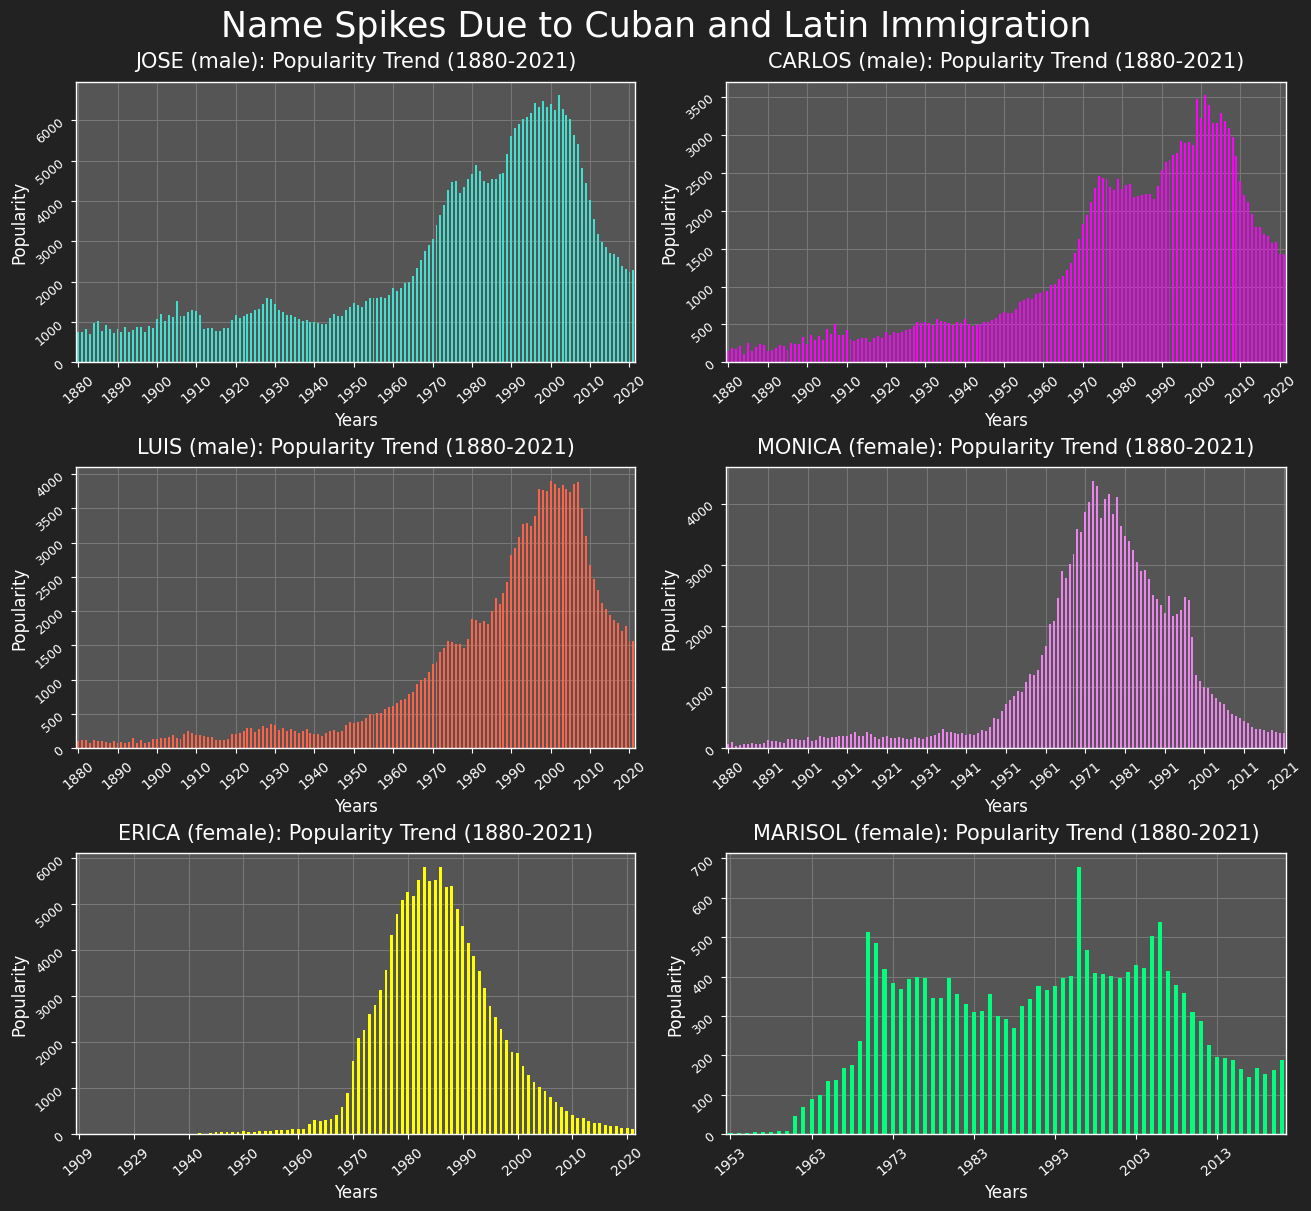

In [375]:
plot_subplots(cuban_names, "Name Spikes Due to Cuban and Latin Immigration")

--- 
---
## → Most popular unisex names
<br>

#### `df.unstack()`: [docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html)
```
DataFrame.unstack(level=- 1, fill_value=None)[source]

Pivot a level of the (necessarily hierarchical) index labels.

Returns a DataFrame having a new level of column labels whose inner-most level consists of the pivoted index labels.

If the index is not a MultiIndex, the output will be a Series (the analogue of stack when the columns are not a MultiIndex).

Parameters

    levelint, str, or list of these, default -1 (last level)

        Level(s) of index to unstack, can pass level name.
    fill_valueint, str or dict

        Replace NaN with this value if the unstack produces missing values.

Returns

    Series or DataFrame
```

### ⤹ Unisex names defined as any that have no NaN values in either gender column

In [59]:
unisex = names.groupby(['name', 'gender']).year_count.sum().unstack()
unisex.F = unisex.F.replace(0, np.nan)
unisex.M = unisex.M.replace(0, np.nan)
unisex = unisex.dropna()
unisex.sample(5)

gender      F     M
name               
Johanny   343    42
Caylen    633   335
Ola     29592   624
Kayson    245 10245
Kyante      5    17

### ⤹ Unisex names that have the minimal difference between the genders

In [60]:
unisex_names = unisex.min(axis=1).sort_values(ascending=False).index
unisex.loc[unisex_names].head(8)

gender      F      M
name                
Willie 146165 449559
Jordan 133246 387272
Leslie 268628 112843
Taylor 325832 111763
Jessie 168626 110714
Riley  123172  98494
Angel   97855 245960
Terry   96917 423697

### ⤹ Unisex names where the lower count gender has at least 15,000 count

In [61]:
unisex = unisex[unisex.min(axis=1) > 15000]
print(f"\nThere are {len(unisex)} unisex names with 15,000 records or more.")
print("Here are 5 random examples from that grouping.")
unisex.sample(5)


There are 88 unisex names with 15,000 records or more.
Here are 5 random examples from that grouping.


gender      F       M
name                 
Jody    55775   31383
Bobbie  88347   18403
Morgan 218836   43470
Ollie   41270   16781
James   23595 5202714

### ⤹ Unisex names mostly evenly split between males and females

In [62]:
pd.options.display.float_format = '{:.2f}'.format
top_uni = abs(unisex.F.div(unisex.M).sub(1)).sort_values().head(8)
top_uni_names = list(top_uni.index)
print(f"\nThese are the top 8 names unisex names and how evenly they are distributed between genders.")
top_uni


These are the top 8 names unisex names and how evenly they are distributed between genders.


name
Kerry     0.02
Justice   0.06
Robbie    0.06
Emerson   0.07
Frankie   0.16
Jackie    0.16
Quinn     0.20
Riley     0.25
dtype: float64

In [63]:
top_uni_df = unisex.loc[top_uni_names].head(8)
top_uni_df

gender          F        M
name                      
Kerry    48610.00 49770.00
Justice  17793.00 18887.00
Robbie   22381.00 21119.00
Emerson  26304.00 28321.00
Frankie  34954.00 41376.00
Jackie   90928.00 78684.00
Quinn    41171.00 34303.00
Riley   123172.00 98494.00

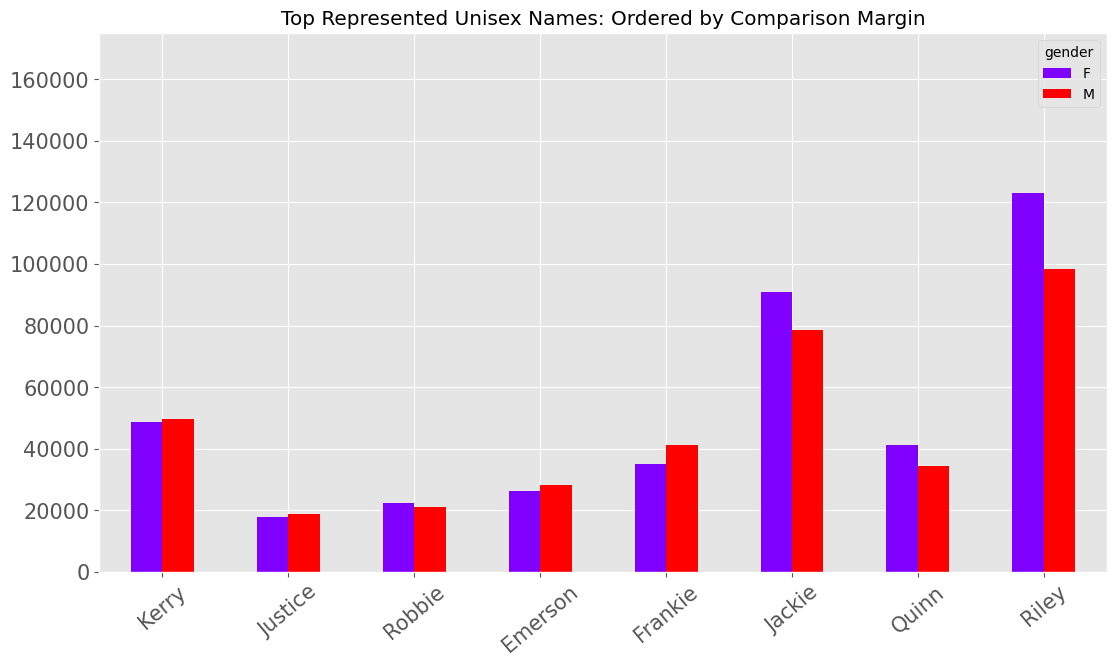

In [81]:
top_uni_df.plot(kind = "bar", figsize = (13, 7), fontsize = 15, title="Top Represented Unisex Names: Ordered by Comparison Margin", grid = True, style = 'ggplot', xlabel = "", ylim = (0, 175000), colormap = 'rainbow', rot = 40);

--- 
---
## → `names_agg` - aggregation of the dataset for further analysis
* COLUMNS:<br>
    - `overall` - total appearances<br>
    - `years_used` - over how many differnt years<br>
    - `first_used` - first year of appearance<br>
    - `last_used` - last year of appearance<br>
    - `highest_year_count` - highest count in a year ever<br>
    - `highest_year` - year with the highest count<br>

In [176]:
names_agg = names.groupby(['name', 'gender']).agg(overall = ('year_count', 'sum'), 
                                                  years_used = ('year_count', 'count'), 
                                                  first_used = ('year', 'min'),
                                                  last_used = ('year', 'max'),
                                                  highest_year_count = ('year_count','max')).dropna().astype(int)

In [191]:
def highest_year(combination):
    return combination.nlargest(1, 'year_count').year

highest_year = names.groupby(['name', 'gender']).apply(highest_year)
names_agg['highest_year'] = highest_year.droplevel(-1)
names_agg.reset_index(inplace = True)
highest_year.droplevel(-1)

In [65]:
# names.to_csv('names_v01.csv')
# names_agg.to_csv('names_aggregated.csv')
names_agg = pd.read_csv("names_aggregated.csv")

In [66]:
names_agg.sample(5)

Unnamed: 0      name gender  overall  years_used  first_used  \
18882       18882    Chares      M       69          11        1939   
30082       30082     Dyami      M      341          35        1976   
50240       50240  Jonathna      M        5           1        1988   
26036       26036   Deklynn      F      130          11        2011   
41064       41064     Husna      F      546          27        1995   

       last_used  highest_year_count  highest_year  
18882       1975                  10          1961  
30082       2021                  23          2005  
50240       1988                   5          1988  
26036       2021                  17          2013  
41064       2021                  50          2017

### ⤹ Aggregated data from the most popular names across most years

In [67]:
to_concatenate = [('Emma', 'F'),
                  ('Elizabeth', 'F'),
                  ('Ella', 'F'),
                  ('William', 'M'),
                  ('James', 'M'),
                  ('Michael', 'M'),
                  ('Robert', 'M'),
                  ('John', 'M')]

In [68]:
def aggregate_list(names_genders_list):
    entries = []
    for name in names_genders_list:
        entry = names_agg[(names_agg.name == name[0]) & (names_agg.gender == name[1])]
        entries.append(entry)

    results = pd.concat(entries, axis = 0, keys = years, names = 
                        ['year']).droplevel(-1).reset_index()


    return results.nlargest(9, "overall")

In [69]:
popular_names = aggregate_list(to_concatenate)
popular_names

year  Unnamed: 0       name gender  overall  years_used  first_used  \
4  1884       44958      James      M  5202714         142        1880   
7  1887       49869       John      M  5150510         142        1880   
6  1886       87127     Robert      M  4834094         142        1880   
5  1885       73212    Michael      M  4392696         142        1880   
3  1883      107773    William      M  4156142         142        1880   
1  1881       31619  Elizabeth      F  1661030         142        1880   
0  1880       32564       Emma      F   721534         142        1880   
2  1882       31678       Ella      F   327581         142        1880   

   last_used  highest_year_count  highest_year  
4       2021               94762          1947  
7       2021               88321          1947  
6       2021               91651          1947  
5       2021               92723          1957  
3       2021               66996          1947  
1       2021               20749          1990  
0       2021               22711          2003  
2       2021                9879          2010

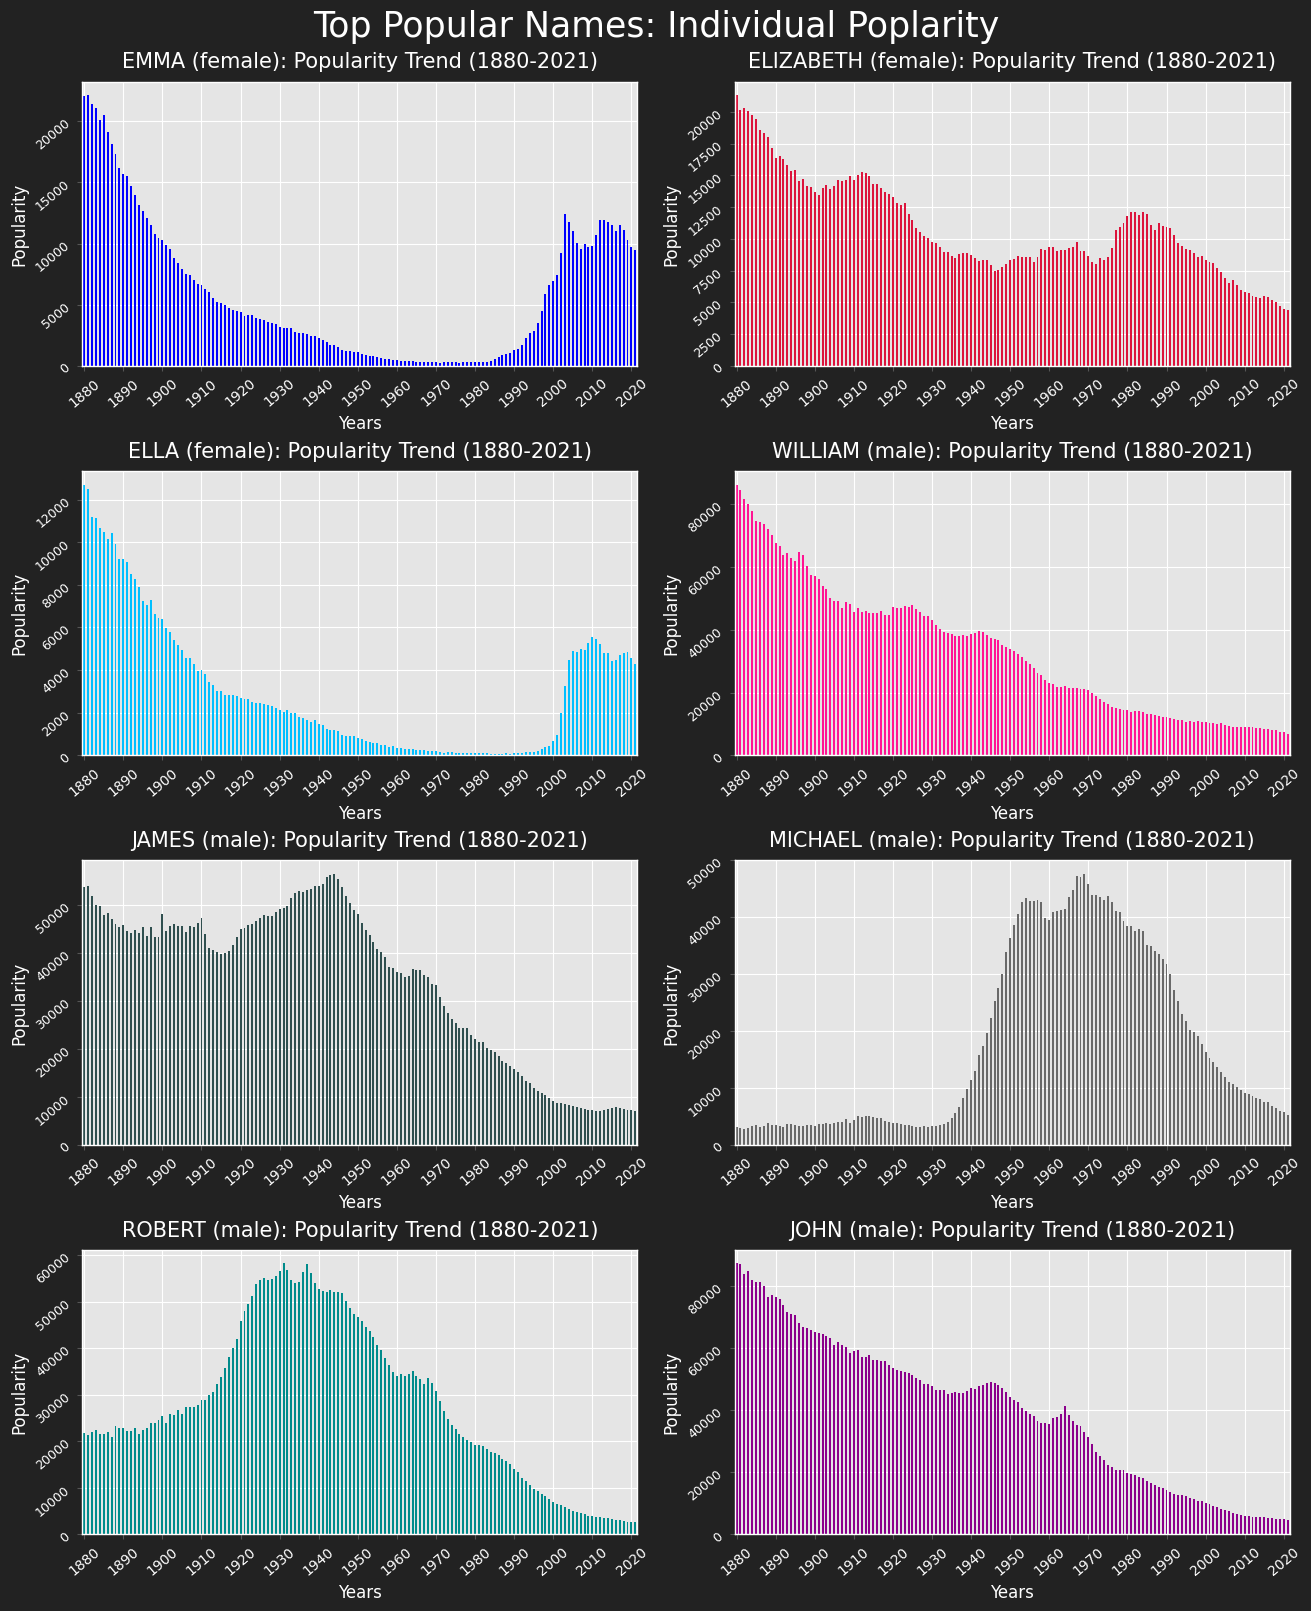

In [78]:
plot_subplots(to_concatenate, "Top Popular Names: Individual Poplarity")

### ⤹ Adding `variation_score` column to the aggregated data

In [71]:
names_agg["variation_score"] = names_agg.highest_year.div(names_agg.overall).mul(100)
names_agg.sample(5)

Unnamed: 0      name gender  overall  years_used  first_used  \
25216        25216    Daydra      F       18           3        1970   
27595        27595   Deuntay      M       22           4        1993   
103232      103232   Travona      F       10           2        1987   
32217        32217    Elysse      F      741          41        1953   
65159        65159  Lisabeth      F     1264          65        1938   

        last_used  highest_year_count  highest_year  variation_score  
25216        1988                   7          1970         10944.44  
27595        2001                   7          1999          9086.36  
103232       1996                   5          1987         19870.00  
32217        2021                  35          1987           268.15  
65159        2018                  61          1958           154.91

### ⤹ The names that have stayed persistent in their level of popularity, i.e. lowest variation

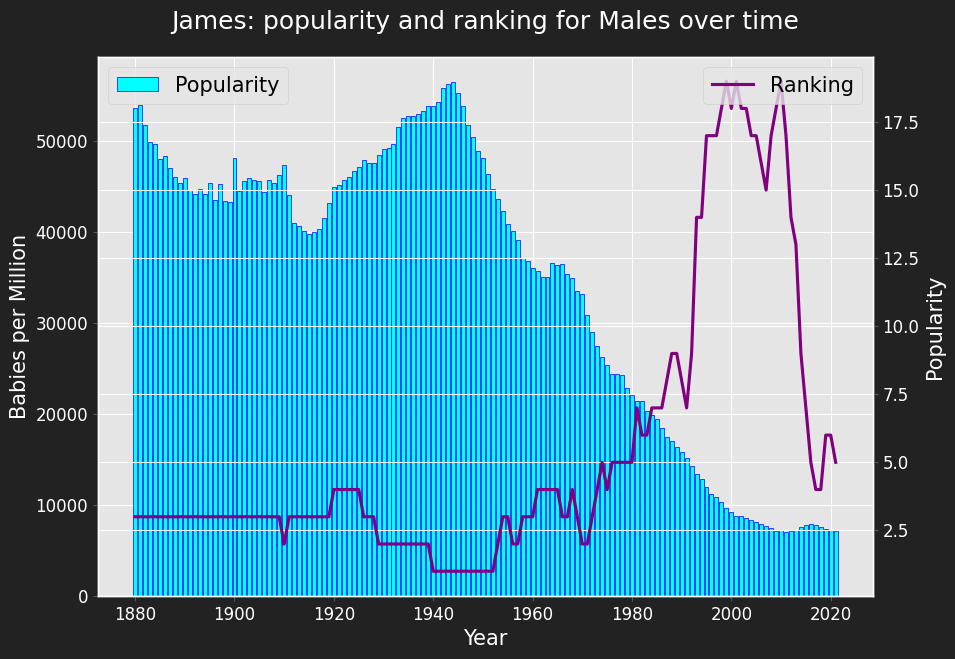

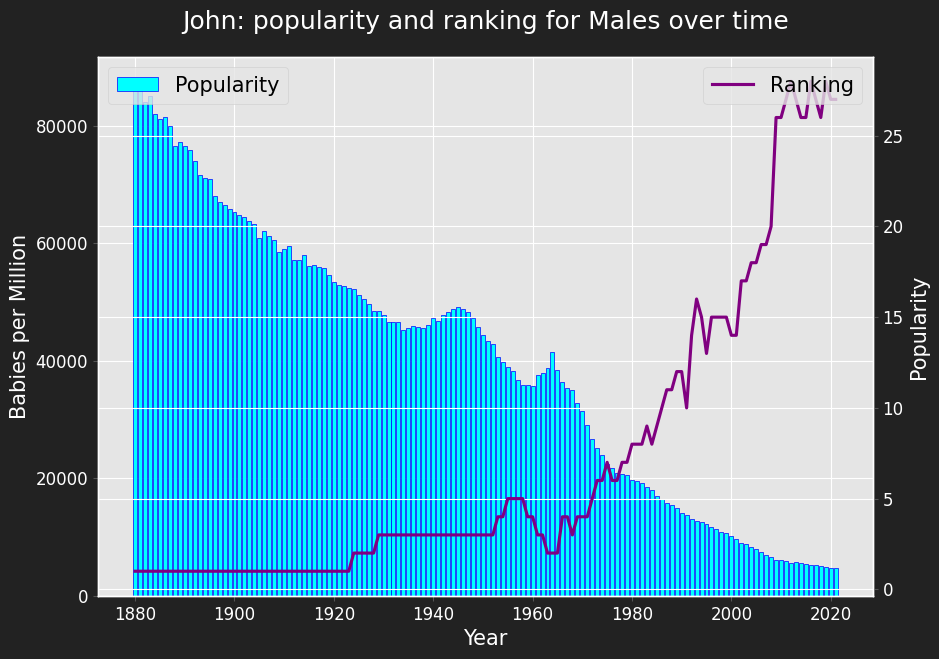

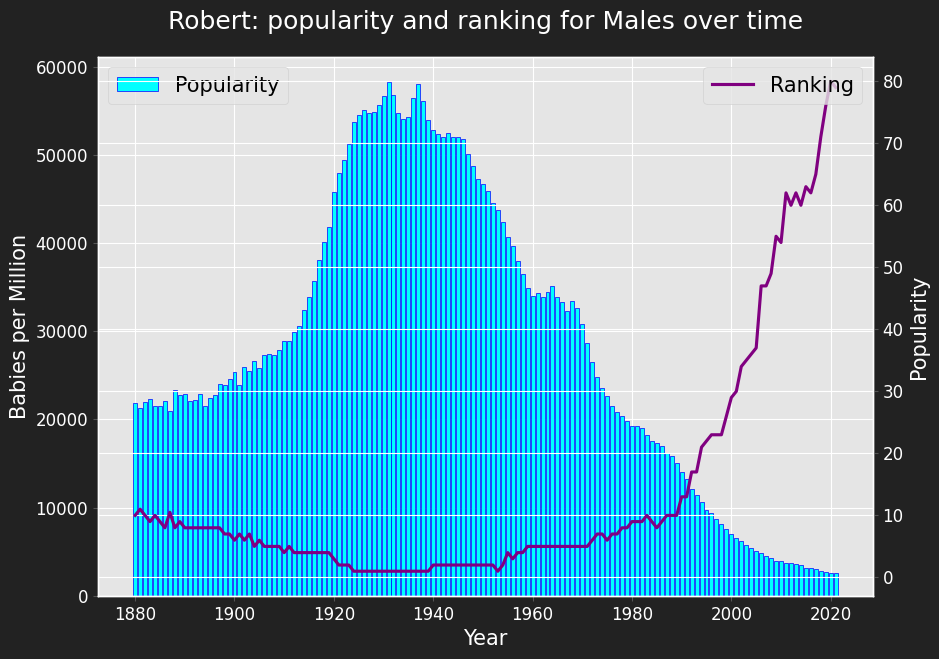

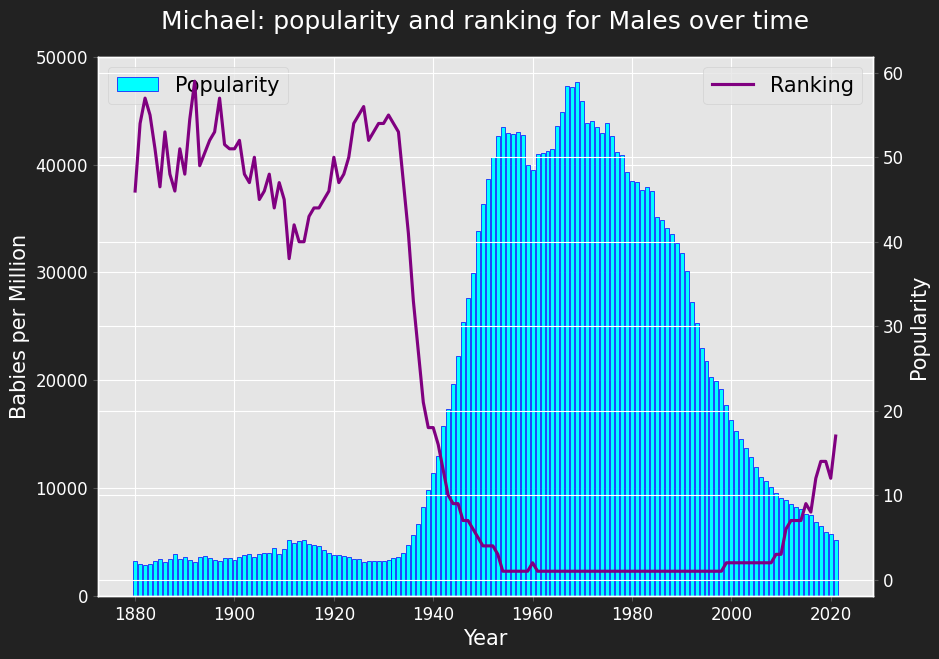

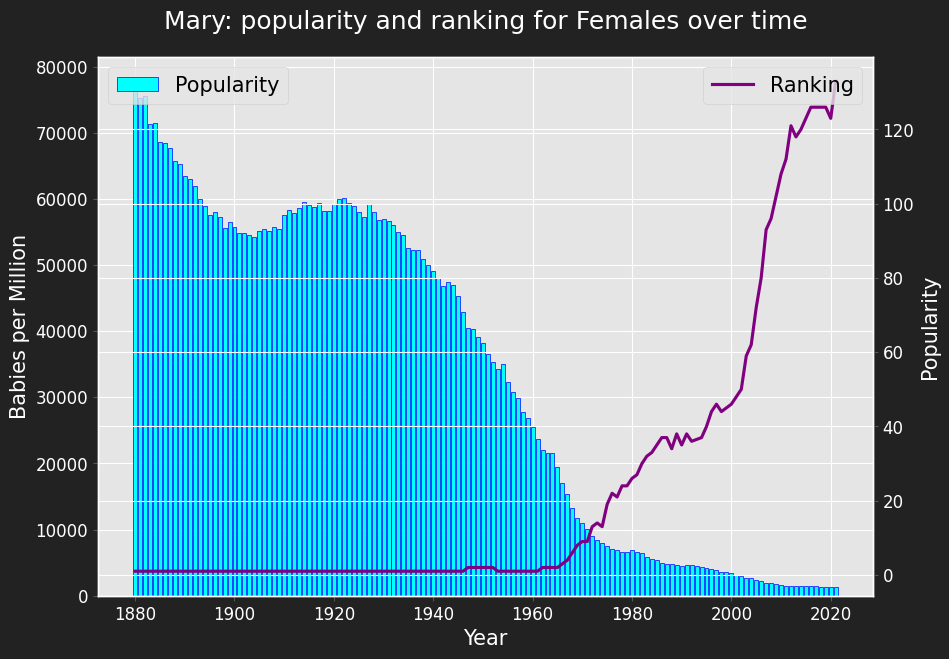

In [72]:
persistent_names = names_agg.sort_values(by = "variation_score", ascending = True).head(5)
persistent_list = list(zip(persistent_names.name, persistent_names.gender))
for name in persistent_list:
    popularity_vs_ranking(name = name[0], gender = name[1])

### ⤹ The names that have had the greatest variation in their level of popularity

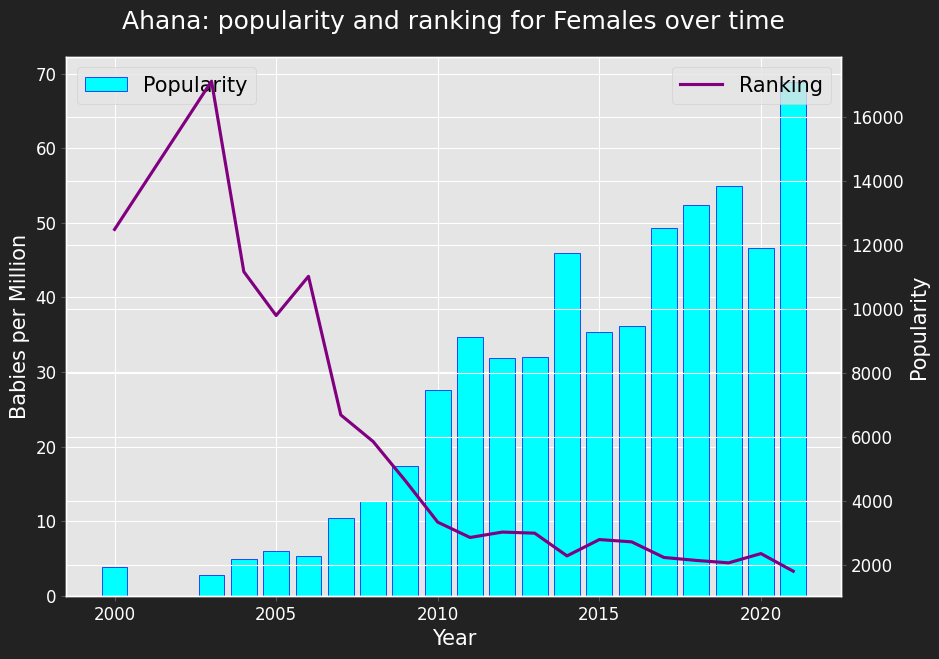

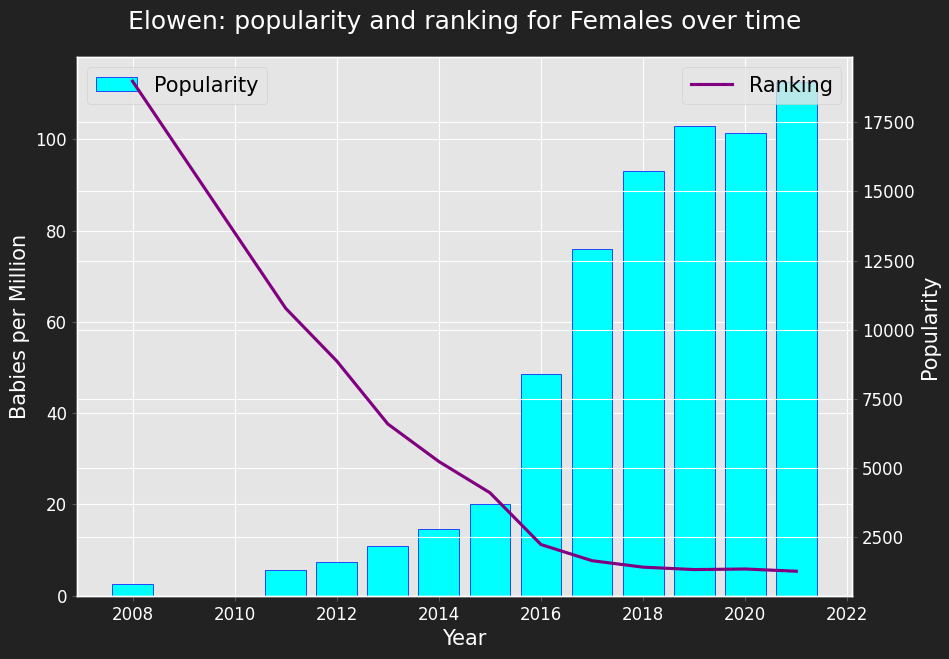

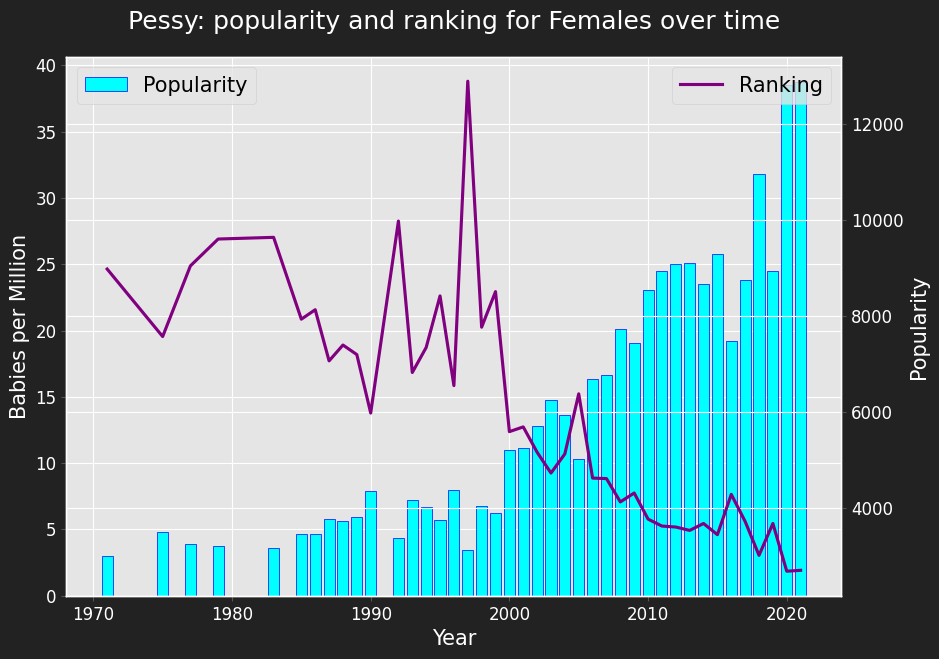

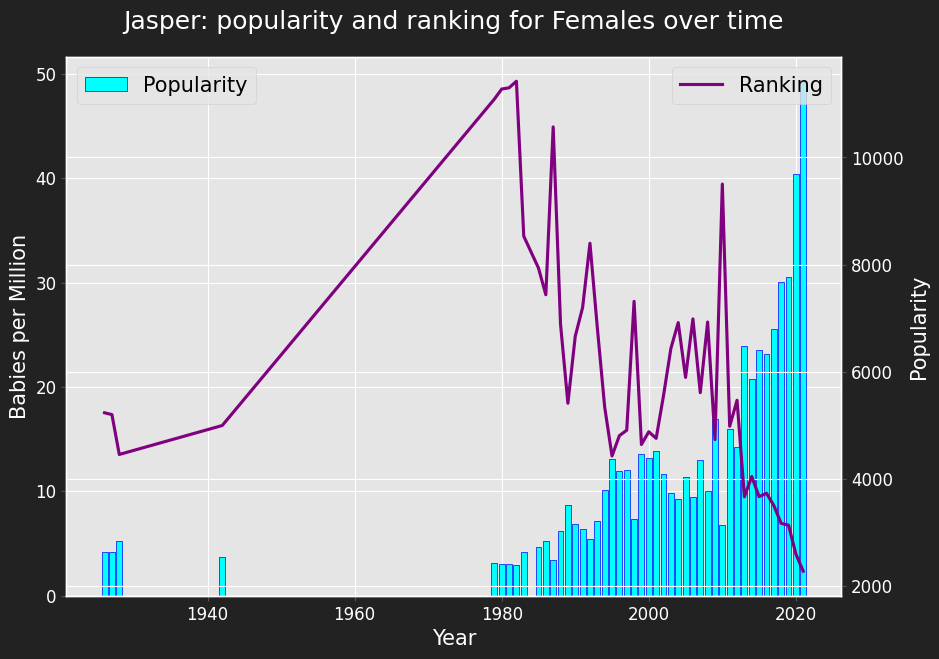

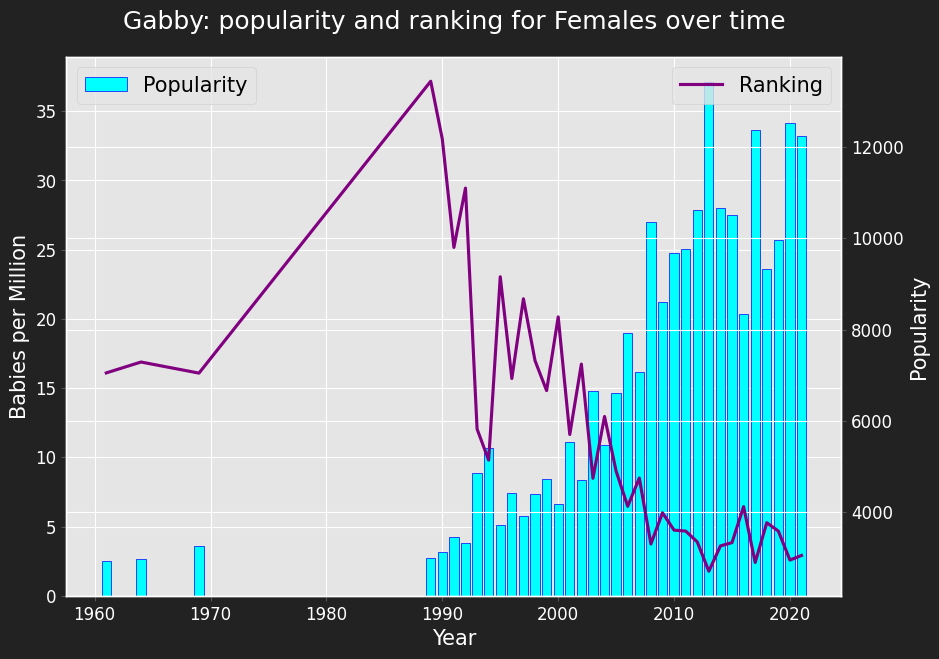

In [73]:
spikey = names_agg[(names_agg.overall > 1000) & \
                   (names_agg.years_used > 10)].sort_values(by = 'variation_score',
                                                          ascending = False).head(5)

spikey_list = list(zip(spikey.name, spikey.gender))

for name in spikey_list:
    popularity_vs_ranking(name[0], name[1])